In [1]:
import copy
import h5py
import numpy as np
import os
import pandas as pd
import sys
import scipy.interpolate
import tqdm
import unyt
import verdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import matplotlib.patheffects as path_effects
import palettable

In [3]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

don't have phil's colormaps


In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.astro as astro_tools

In [5]:
import luminosity_yu

In [6]:
import linefinder.utils.file_management as file_management_old
import linefinder.utils.file_management_new as file_management
import linefinder.config as config

In [7]:
import trove

# Load Data

### Parameters

In [8]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    script_id = 'nb.2',
    variation = 'm12b_md',
    global_variation = '',
    flag_for_potentially_fixing_potential_bug_in_calculating_potential = True,
)

In [9]:
pm['sim_data_dir']

'/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12b_res7100/output'

In [10]:
# Halo file params
mt_kwargs = {
    'tag': 'smooth',
}

In [11]:
# Data selection params
snum = 600
t_window = 1. # In Gyr
galdef = ''
galaxy_cut = 0.1
length_scale = 'Rvir'

In [12]:
# Properties to load into the data frame, used for analysis
df_props_star = [ 'ID', 'Rx', 'Ry', 'Rz', 'R', 'L', 'M' ]
df_props = df_props_star + [ 'Den', 'T' ]

In [13]:
store_child_ids = False

### Get Data Structures

In [14]:
fm = file_management.FileManager( 'hot_accretion' )
fm_old = file_management_old.FileManager( 'hot_accretion' )

In [15]:
ind = 600 - snum

In [16]:
g_data = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

In [17]:
s_data = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

In [18]:
d_data = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum,
    ptype = config.PTYPE_DM,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

In [19]:
# Load a time data array
time = astro_tools.age_of_universe(
    g_data.halo_data.get_mt_data( 'redshift', ),
    h = g_data.data_attrs['hubble'],
    omega_matter = g_data.data_attrs['omega_matter'],
)

In [20]:
# Find the time
prev_time_inds = np.arange(time.size)[np.isclose( time[ind] - t_window, time, atol=0.012 )]
assert prev_time_inds.size == 1
prev_time_ind = prev_time_inds[0]
snum_prior = 600 - prev_time_ind

In [21]:
g_data_prior = particle_data.ParticleData(
    sdir = pm['sim_data_dir'],
    snum = snum_prior,
    ptype = config.PTYPE_GAS,
    halo_data_dir = pm['halo_data_dir'],
    main_halo_id = 0,
    load_additional_ids = store_child_ids,
)

# Select Data

### Particles in the Galaxy Later

In [22]:
# Find characteristic length scale of the galaxy
len_scale = g_data.halo_data.get_mt_data(
    length_scale,
    snums=[snum,],
    mt_halo_id=g_data.main_halo_id
)
r_gal = galaxy_cut * len_scale

In [23]:
# Find gas particles in the main galaxy
is_in_gal_gas = (
    ( g_data.get_data( 'R' ) < r_gal ) &
    ( g_data.get_data( 'Den' ) > config.GALAXY_DENSITY_CUT )
)

In [24]:
# Find star particles in the main galaxy
is_in_gal_star = s_data.get_data( 'R' ) < r_gal

In [25]:
# Retrieve the relevant IDs
ids_gal = np.concatenate(
    (
        g_data.get_data( 'ID' )[is_in_gal_gas],
        s_data.get_data( 'ID' )[is_in_gal_star]
    )
)

In [26]:
if store_child_ids:
    child_ids_gal = np.concatenate(
        (
            g_data.get_data( 'ChildID' )[is_in_gal_gas],
            s_data.get_data( 'ChildID' )[is_in_gal_star]
        )
    )

### Particles in the CGM Earlier

In [27]:
# Find the CGM inner edge
len_scale_prior = g_data_prior.halo_data.get_mt_data(
    config.LENGTH_SCALE,
    snums=[snum_prior,],
    mt_halo_id=g_data.main_halo_id
)
cgm_inner_scale = 1.2 * config.GALAXY_CUT * len_scale_prior
cgm_inner_rvir = config.INNER_CGM_BOUNDARY * g_data_prior.r_vir
cgm_inner = max( cgm_inner_scale, cgm_inner_rvir )

In [28]:
is_in_CGM = g_data_prior.get_data( 'R' ) > cgm_inner

In [29]:
ids_cgm = g_data_prior.get_data( 'ID' )[is_in_CGM]

In [30]:
if store_child_ids:
    child_ids_cgm = g_data_prior.get_data( 'ChildID' )[is_in_CGM]

### Particles that Accreted

In [31]:
ids_accreted_alt = np.intersect1d( ids_gal, ids_cgm )

In [32]:
if store_child_ids:
    ids_str_gal = [ '{}_{}'.format( ids_gal[i], child_ids_gal[i] ) for i in range( ids_gal.size ) ]
    ids_str_cgm = [ '{}_{}'.format( ids_cgm[i], child_ids_cgm[i] ) for i in range( ids_cgm.size ) ]
    ids_str_accreted = np.intersect1d( ids_str_gal, ids_str_cgm )
    ids_accreted, child_ids_accreted = np.array( [ _.split( '_' ) for _ in ids_str_accreted ] ).astype( int ).transpose()
else:
    ids_accreted = ids_accreted_alt

In [33]:
if store_child_ids:
    extra_ids = np.array( list( set( ids_accreted_alt ) - set( ids_accreted ) ) )

### Stars formed within the last Gyr
And in the main galaxy

In [34]:
h_param = s_data.data_attrs['hubble']

In [35]:
z_star = ( 1. / s_data.get_data( 'Age' ) - 1. )
universe_age = astro_tools.age_of_universe( z_star, h_param, s_data.data_attrs['omega_matter'])
lookback_time = astro_tools.age_of_universe( 0., h_param, s_data.data_attrs['omega_matter']) - universe_age
recent = lookback_time < 1.

In [36]:
ids_recent = s_data.get_data( 'ID' )[recent & is_in_gal_star]

### Thin disk stars

In [37]:
# Star masses enclosed
r_star = s_data.get_data( 'R' )[is_in_gal_star]
r_star[r_star > s_data.r_vir] = np.nan
if pm['flag_for_potentially_fixing_potential_bug_in_calculating_potential']:
    r_star_ckpc = r_star * ( h_param * ( 1. + s_data.redshift ) )
else:
    r_star_ckpc = r_star / ( h_param * ( 1. + s_data.redshift ) )
M_enc_star = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_star_ckpc
) / h_param

In [38]:
# Get grid masses enclose
r_grid = np.linspace( 0.00001, s_data.r_vir, 1024 )
if pm['flag_for_potentially_fixing_potential_bug_in_calculating_potential']:
    r_grid_ckpc = r_grid * ( h_param * ( 1. + s_data.redshift ) )
else:
    r_grid_ckpc = r_grid / ( h_param * ( 1. + s_data.redshift ) )
M_enc_grid = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_grid_ckpc
) / h_param
M_enc_grid[np.isnan(M_enc_grid)] = 0.
M_enc_grid[np.arange(M_enc_grid.size)>np.argmax(M_enc_grid)] = M_enc_grid.max()

In [39]:
# Get potential energy
pot_grid = unyt.G * scipy.integrate.cumtrapz( M_enc_grid/r_grid**2., r_grid, initial=0 ) * unyt.Msun / unyt.kpc
pot_grid -= pot_grid[-1]
pot_grid -= unyt.G * g_data.m_vir * unyt.Msun / ( g_data.r_vir * unyt.kpc )
pot_grid = pot_grid.to( 'm**2/s**2' )
pot_fn = lambda x : scipy.interpolate.interp1d( r_grid, pot_grid )( x ) * unyt.m**2. / unyt.s**2.

In [40]:
# Get energy for a grid, using virial theorem
spec_e_grid = pot_grid + 0.5 * unyt.G * M_enc_grid * unyt.Msun / ( r_grid * unyt.kpc )

In [41]:
# Star potential energy, specific energy
pot_star = pot_fn( r_star )
v_star = s_data.get_data( 'Vmag' )[is_in_gal_star] * unyt.km / unyt.s
spec_e_star =  pot_star +  0.5 * v_star**2.

In [42]:
# What radii particles would be at if they were circular with the same energy
spec_e_star[spec_e_star>spec_e_grid.max()] = np.nan
r_circ = scipy.interpolate.interp1d( spec_e_grid, r_grid )( spec_e_star )

In [43]:
# Circular momentum
if pm['flag_for_potentially_fixing_potential_bug_in_calculating_potential']:
    r_circ_ckpc = r_circ * ( h_param * ( 1. + s_data.redshift ) )
else:
    r_circ_ckpc = r_circ / ( h_param * ( 1. + s_data.redshift ) )
M_enc_circ = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_circ_ckpc
) / h_param
j_circ = np.sqrt( unyt.G * M_enc_circ * unyt.Msun * r_circ * unyt.kpc)

In [44]:
# Angular momentum
ang_mom_dir = s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum )
l_units = unyt.Msun * unyt.kpc * unyt.km / unyt.s
lz_star = np.dot( s_data.get_data( 'L', ).transpose(), ang_mom_dir )[is_in_gal_star] * l_units
lmag_star = s_data.get_data( 'Lmag' )[is_in_gal_star] * l_units
m_star = s_data.get_data( 'M' )[is_in_gal_star] * unyt.Msun
jz_star = lz_star / m_star
jmag_star = lmag_star / m_star

In [45]:
# Ratios
jz_jcirc = jz_star / j_circ
jz_jmag = jz_star / jmag_star

In [46]:
is_thin_disk = jz_jcirc > 0.8
ids_thin_disk = s_data.get_data( 'ID' )[is_in_gal_star][is_thin_disk]

In [47]:
j_circ_corrected = copy.deepcopy( j_circ )
jz_jcirc_corrected = copy.deepcopy( jz_jcirc )

# Plot Selected Data

## After

### Get Spatial Data

In [48]:
# Format Gas Data
data = {}
for key in tqdm.tqdm( df_props ):
    prop = g_data.get_data( key )
    if key != 'L':
        data[key] = prop
    else:
        for i, prop_i in enumerate( prop ):
            data['{}{}'.format( key, i )] = prop_i
df = pd.DataFrame( data )

# Get rid of duplicates
df = df.drop_duplicates( 'ID', keep=False )

df = df.set_index( 'ID' )

100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


In [49]:
# Format Star Data
data = {}
for key in tqdm.tqdm( df_props_star ):
    prop = s_data.get_data( key )
    if key != 'L':
        data[key] = prop
    else:
        for i, prop_i in enumerate( prop ):
            data['{}{}'.format( key, i )] = prop_i
df_star = pd.DataFrame( data )

# Get rid of duplicates
df_star = df_star.drop_duplicates( 'ID', keep=False )

df_star = df_star.set_index( 'ID' )

100%|██████████| 7/7 [00:00<00:00, 80000.35it/s]


In [50]:
# Get rid of shared duplicates
valid_gas = np.invert( df.index.isin( df_star.index ) )
valid_stars = np.invert( df_star.index.isin( df.index ) )

df = df[valid_gas]
df_star = df_star[valid_stars]

In [51]:
is_acc = df.index.isin( ids_accreted )
df_acc = df[is_acc]

In [52]:
if store_child_ids:
    is_extra = df.index.isin( extra_ids )
    df_extra = df[is_extra]

In [53]:
is_acc_star = df_star.index.isin( ids_accreted )
df_acc_star = df_star[is_acc_star]

In [54]:
if store_child_ids:
    is_extra = df_star.index.isin( extra_ids )
    df_extra_star = df_star[is_extra]

### Plot After

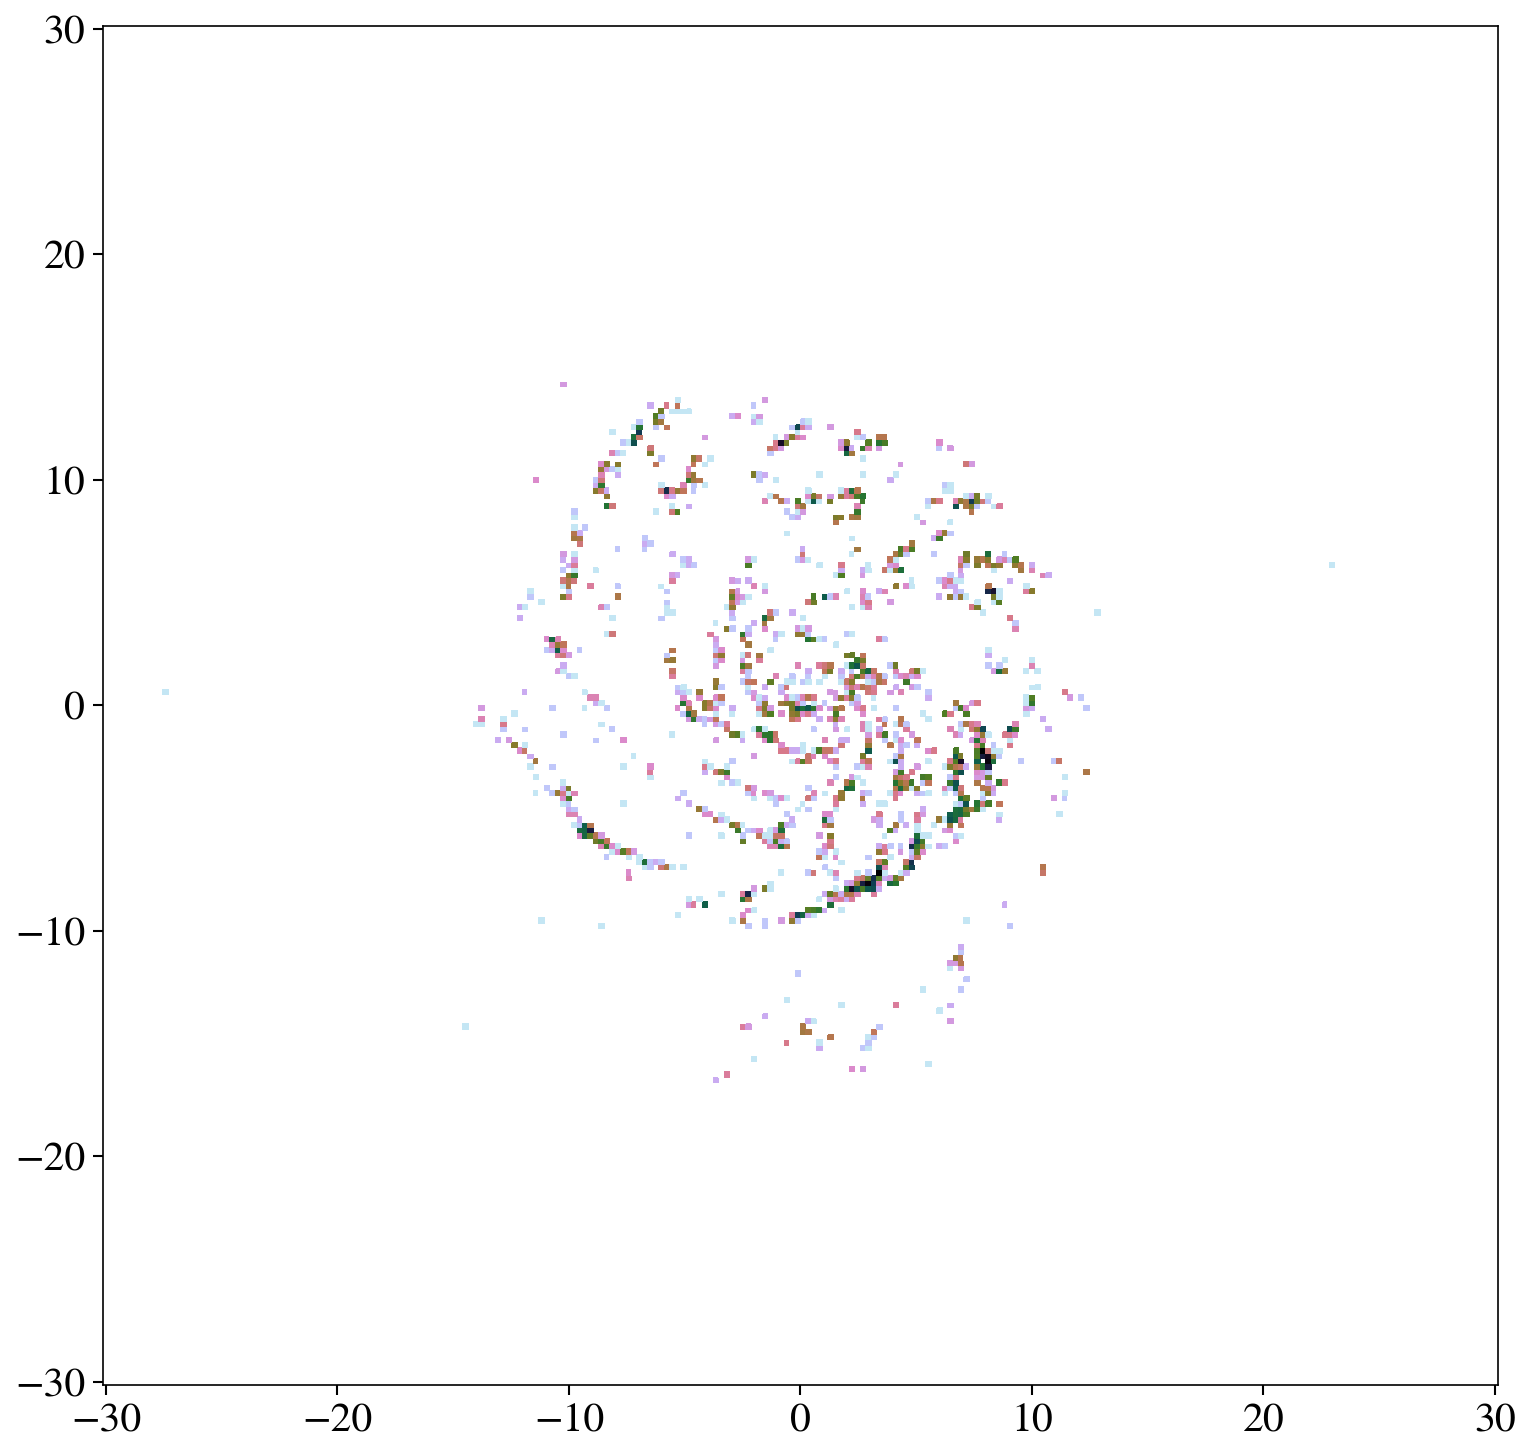

In [55]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_acc['Rx'],
    df_acc['Ry'],
    bins = 256,
    range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

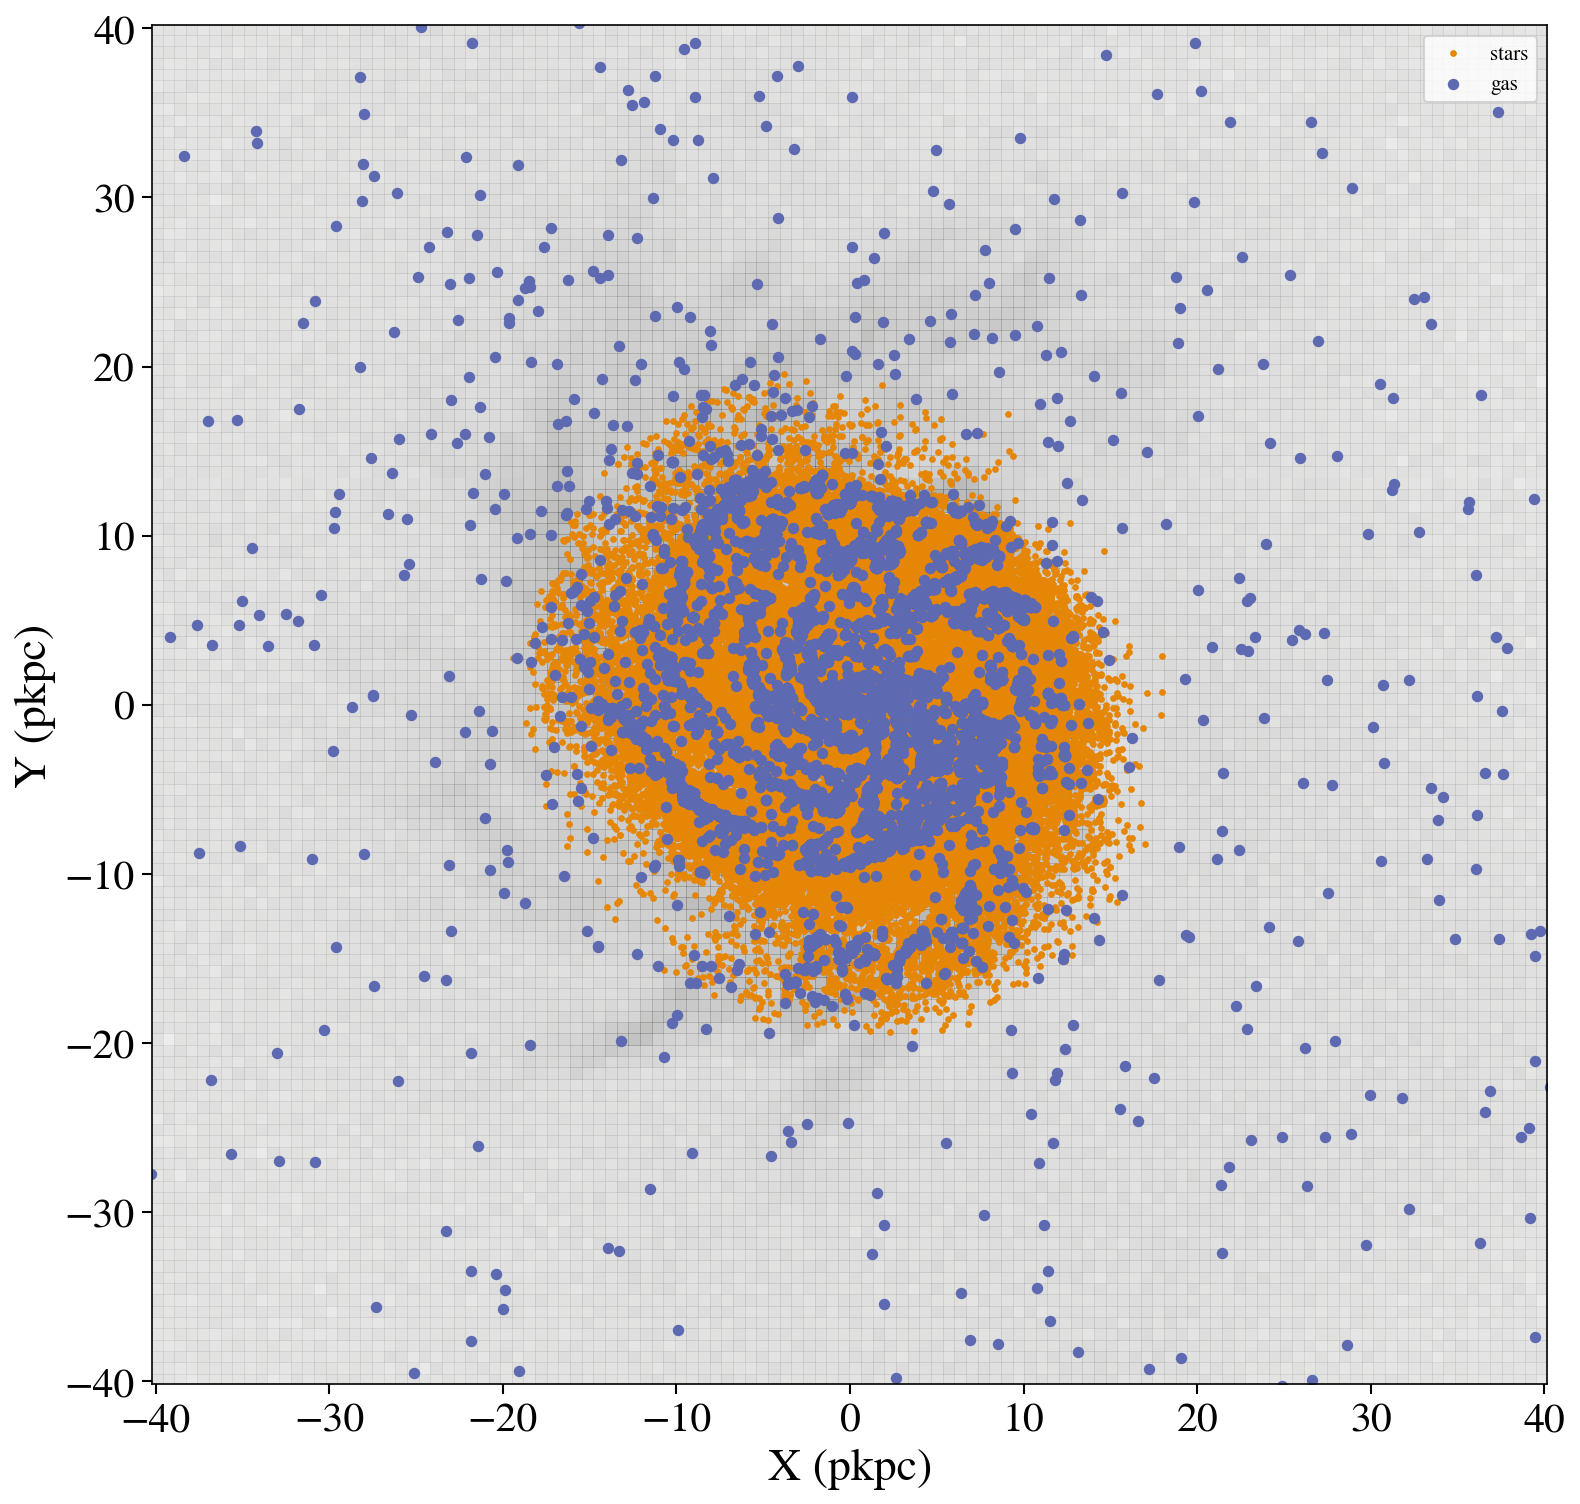

In [56]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    g_data.get_data( 'Rx' ),
    g_data.get_data( 'Ry' ),
    bins = 256,
    range = 0.3 * g_data.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.4,
)

ax.scatter(
    df_acc_star['Rx'],
    df_acc_star['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
    s = 5,
    label = 'stars',
)

ax.scatter(
    df_acc['Rx'],
    df_acc['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 20,
    label = 'gas',
)


ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -2. * r_gal, 2. * r_gal )
ax.set_ylim( -2. * r_gal, 2. * r_gal )

ax.legend()

fig

In [57]:
r_acc = np.sqrt( df_acc['Rx']**2. + df_acc['Rx']**2. + df_acc['Rx']**2. )

In [58]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.hist2d(
        df_extra['Rx'],
        df_extra['Ry'],
        bins = 128,
        range = 1.5 * r_gal * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
        cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
        norm = plt_colors.LogNorm(),
    )

    fig

In [59]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.scatter(
        df_extra['Rx'],
        df_extra['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
        s = 25,
        label = 'gas',
    )
    
    ax.scatter(
        df_extra_star['Rx'],
        df_extra_star['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
        s = 5,
        label = 'stars',
    )


    ax.set_xlabel( 'X (pkpc)', fontsize=22, )
    ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

    ax.set_xlim( -1. * r_gal, 1. * r_gal )
    ax.set_ylim( -1. * r_gal, 1. * r_gal )

    ax.legend()

    fig

## Check Results of Splitting

In [60]:
if store_child_ids:

    g_dups = g_data.find_duplicate_ids()

    s_dups = s_data.find_duplicate_ids()

    gs_dups = np.intersect1d( g_data.get_data( 'ID' ), s_data.get_data( 'ID' ) )

    all_dups = np.union1d( np.union1d( g_dups, s_dups, ), gs_dups )
    
    g_prior_dups = g_data_prior.find_duplicate_ids()

In [61]:
if store_child_ids:

    print( 'Percent of galaxy ids with duplicates = {:.2g}%'.format( np.intersect1d( all_dups, ids_gal ).size / ids_gal.size * 100 ) )

    print( 'Percent of CGM ids with duplicates = {:.2g}%'.format( np.intersect1d( ids_cgm, g_prior_dups ).size / ids_cgm.size * 100 ) )

    print( 'Percent of galaxy ids targeted = {:.2g}%'.format( ids_accreted.size / ids_gal.size * 100 ) )

    print( 'Percent of CGM ids targeted = {:.2g}%'.format( ids_accreted.size / ids_cgm.size * 100 ) )

    n_dups = np.intersect1d( ids_accreted_alt, all_dups ).size

    cgm_before_dup_after = np.intersect1d( ids_cgm, np.intersect1d( all_dups, ids_gal ) )

    dup_before_gal_after = np.intersect1d( ids_gal, np.intersect1d( g_prior_dups, ids_cgm ) )

    dup_before_dup_after = np.intersect1d( np.intersect1d( all_dups, ids_gal ), np.intersect1d( g_prior_dups, ids_cgm )  )

    all_relevant_dup_ids = np.union1d( np.union1d( cgm_before_dup_after, dup_before_gal_after ), dup_before_dup_after )
    
    print( 'Percent of duplicates CGM before, duplicate after = {:.2g}%'.format( cgm_before_dup_after.size / n_dups * 100 ) )

    print( 'Percent of duplicates duplicate before, galaxy after = {:.2g}%'.format( dup_before_gal_after.size / n_dups * 100 ) )

    print( 'Accounted for IDs = {}, number of duplicate IDs = {}'.format( all_relevant_dup_ids.size, np.intersect1d( ids_accreted_alt, all_dups ).size ) )

## Before

### Get Spatial Data

In [62]:
# Format Data
data = {}
for key in tqdm.tqdm( df_props ):
    prop = g_data_prior.get_data( key )
    if key != 'L':
        data[key] = prop
    else:
        for i, prop_i in enumerate( prop ):
            data['{}{}'.format( key, i )] = prop_i
data['is_in_CGM'] = is_in_CGM
df_prior = pd.DataFrame( data )

# Get rid of duplicates
df_prior = df_prior.drop_duplicates( 'ID', keep=False )

df_prior = df_prior.set_index( 'ID' )

100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


In [63]:
df_acc_prior = df_prior[df_prior.index.isin( ids_accreted )]

In [64]:
not_counted = df.index.isin( df_prior.index[df_prior['is_in_CGM']] ) & np.invert( is_acc )
df_not_counted = df[not_counted]

In [65]:
not_counted = df_star.index.isin( df_prior.index[df_prior['is_in_CGM']] ) & np.invert( is_acc_star )
df_not_counted_star = df_star[not_counted]

In [66]:
if store_child_ids:
    df_extra_prior = df_prior[df_prior.index.isin( extra_ids )]

### Plot Before

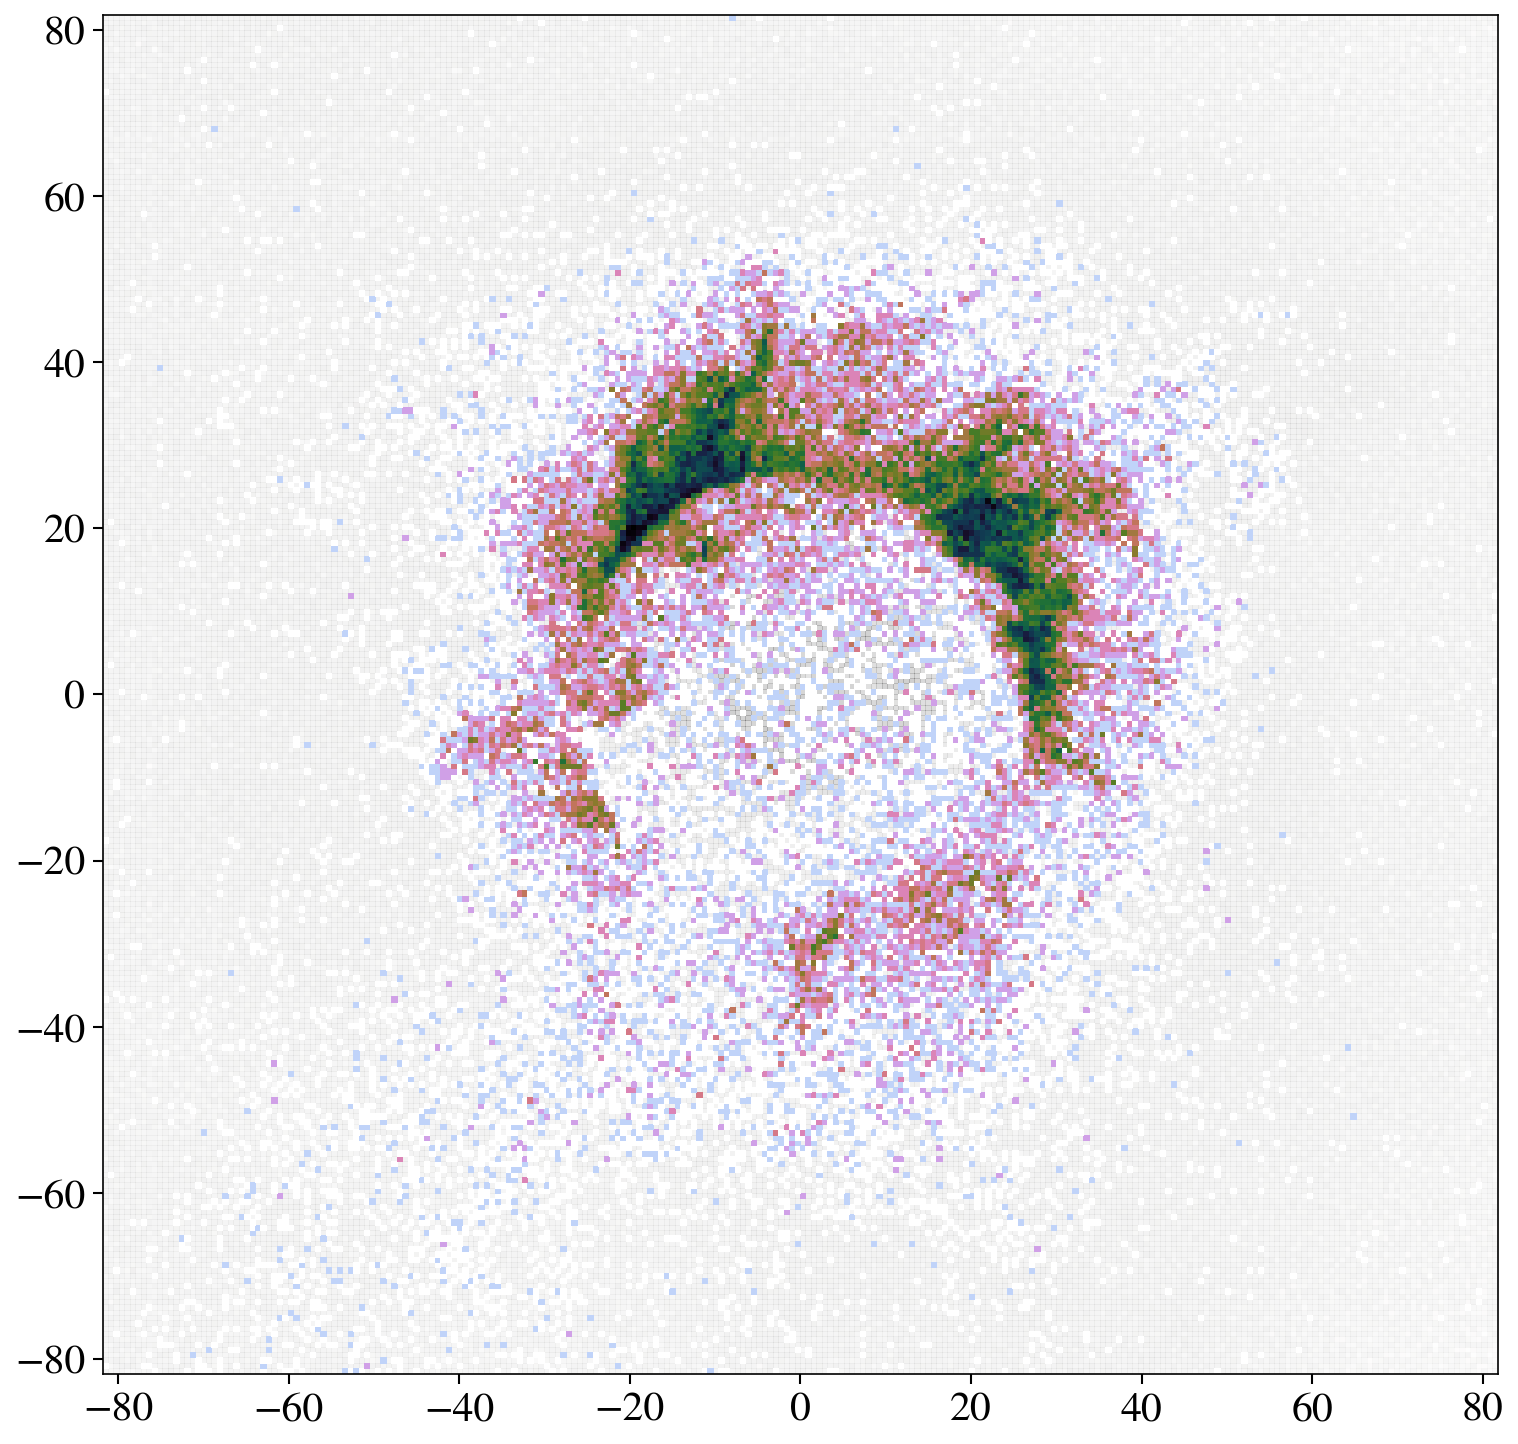

In [67]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    g_data_prior.get_data( 'Rx' ),
    g_data_prior.get_data( 'Ry' ),
    bins = 256,
    range = 0.3 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.2,
)

ax.hist2d(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    bins = 256,
    range = 0.3 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cubehelix.classic_16_r.get_mpl_colormap(),
    norm = plt_colors.LogNorm(),
)

fig

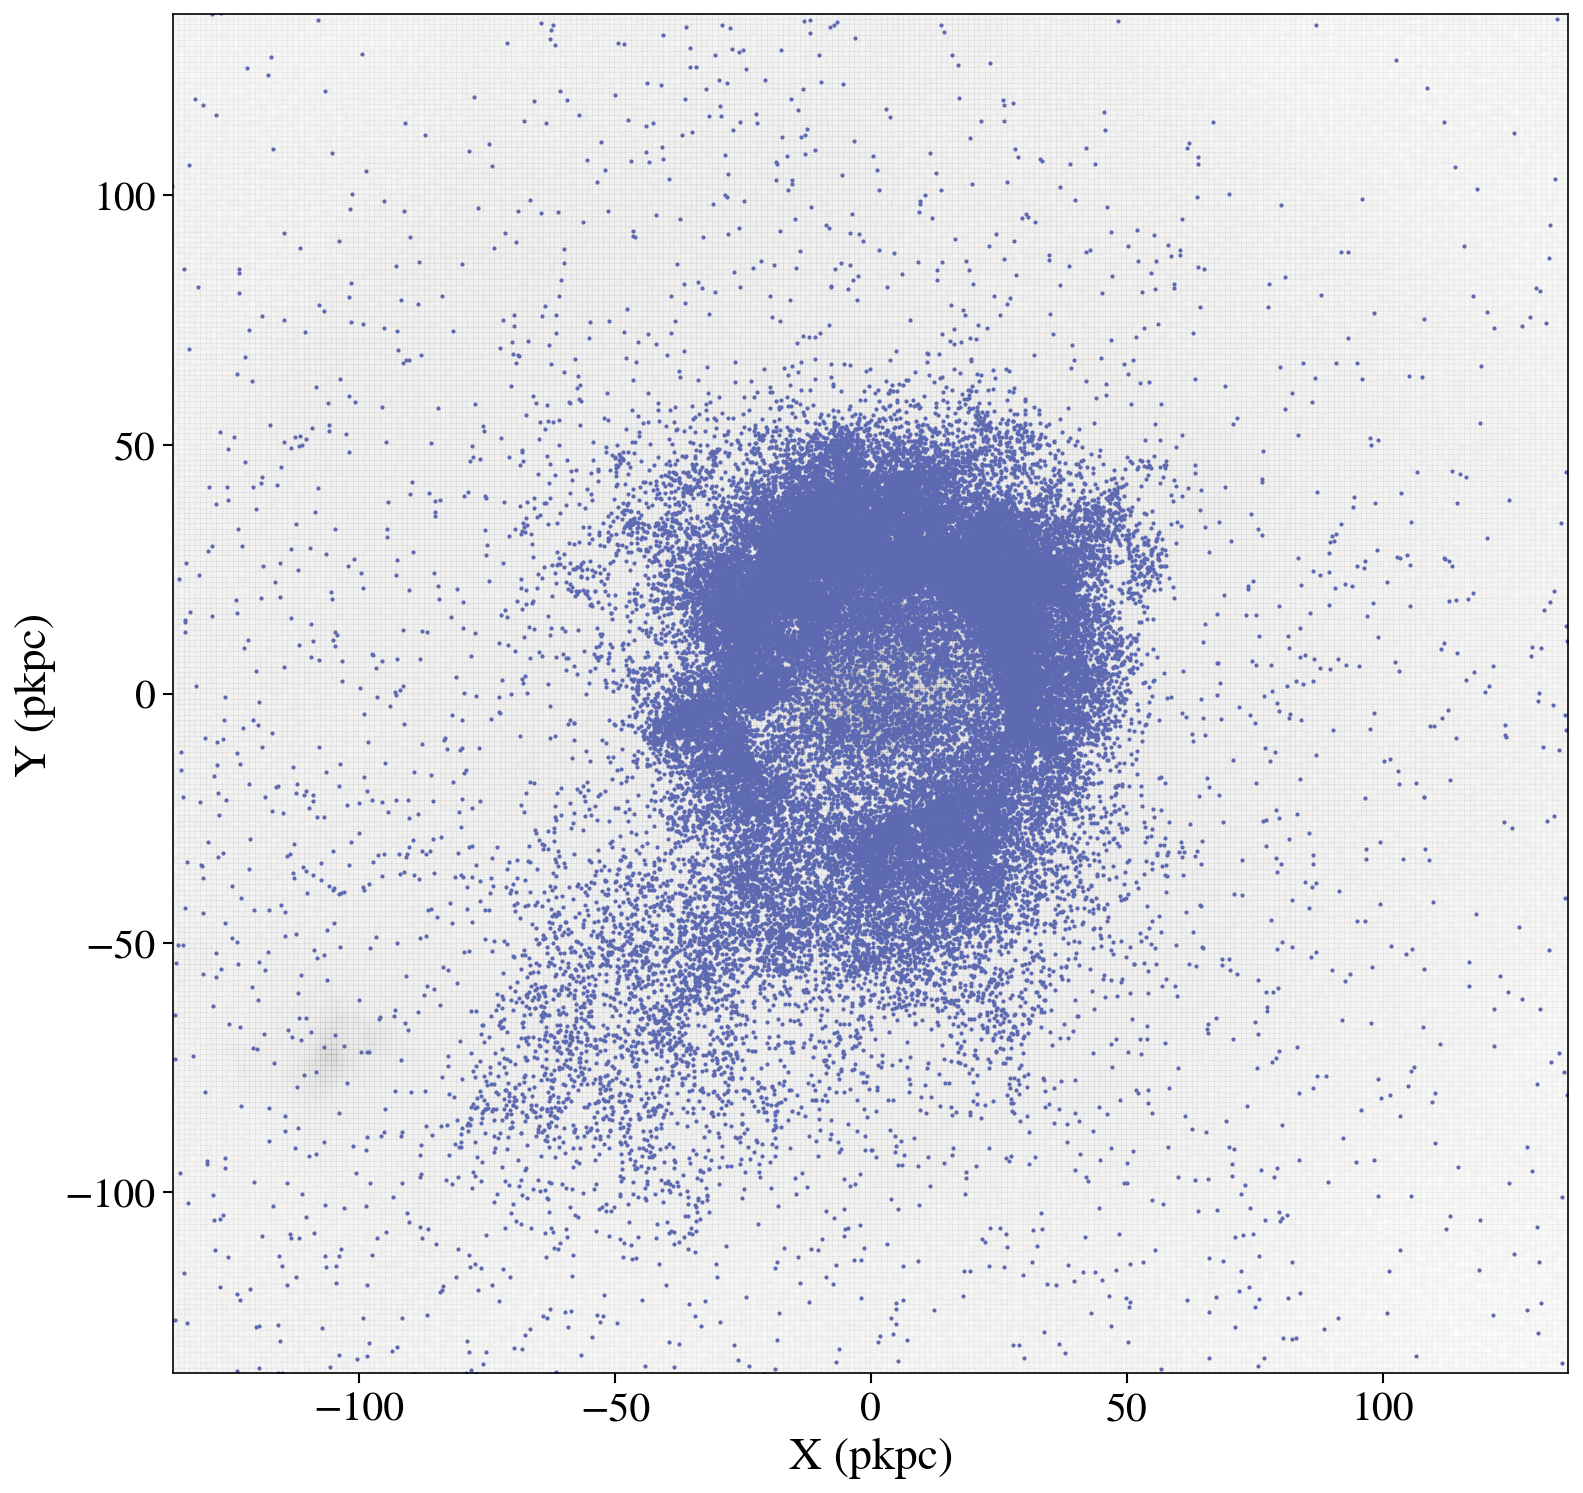

In [68]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    g_data_prior.get_data( 'Rx' ),
    g_data_prior.get_data( 'Ry' ),
    bins = 256,
    range = 0.5 * g_data_prior.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.2,
)

ax.scatter(
    df_acc_prior['Rx'],
    df_acc_prior['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
    s = 1,
)

ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

fig

In [69]:
if store_child_ids:
    fig = plt.figure( figsize=(12, 12), facecolor='white' )
    ax = plt.gca()

    ax.scatter(
        df_extra_prior['Rx'],
        df_extra_prior['Ry'],
        color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[1],
        s = 1,
    )

    ax.set_xlabel( 'X (pkpc)', fontsize=22, )
    ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

    ax.set_xlim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )
    ax.set_ylim( -0.5 * g_data_prior.r_vir, 0.5 * g_data_prior.r_vir )

    fig

### Plot Positions at $z=0$

In [70]:
df_not_counted['R'] = np.sqrt( df_not_counted['Rx']**2. + df_not_counted['Ry']**2. + df_not_counted['Rz']**2. )

<ipython-input-70-2c93706def20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_counted['R'] = np.sqrt( df_not_counted['Rx']**2. + df_not_counted['Ry']**2. + df_not_counted['Rz']**2. )


In [71]:
df_not_counted_star['R'] = np.sqrt( df_not_counted_star['Rx']**2. + df_not_counted_star['Ry']**2. + df_not_counted_star['Rz']**2. )

<ipython-input-71-278ea6e0f05d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_counted_star['R'] = np.sqrt( df_not_counted_star['Rx']**2. + df_not_counted_star['Ry']**2. + df_not_counted_star['Rz']**2. )


In [72]:
print( 'r_star_min_not_counted = {:.3g} kpc; r_gal = {:.3g} kpc'.format( df_not_counted_star['R'].min(), r_gal[0] ) )
assert df_not_counted_star['R'].min() > r_gal, 'r_star_min_not_counted too small'

r_star_min_not_counted = 20.1 kpc; r_gal = 20.1 kpc


In [73]:
in_rgal = df_not_counted['R'] < r_gal[0]
is_dense = df_not_counted['Den'] > config.GALAXY_DENSITY_CUT
in_gal_not_counted = in_rgal & is_dense
assert in_gal_not_counted.sum() == 0

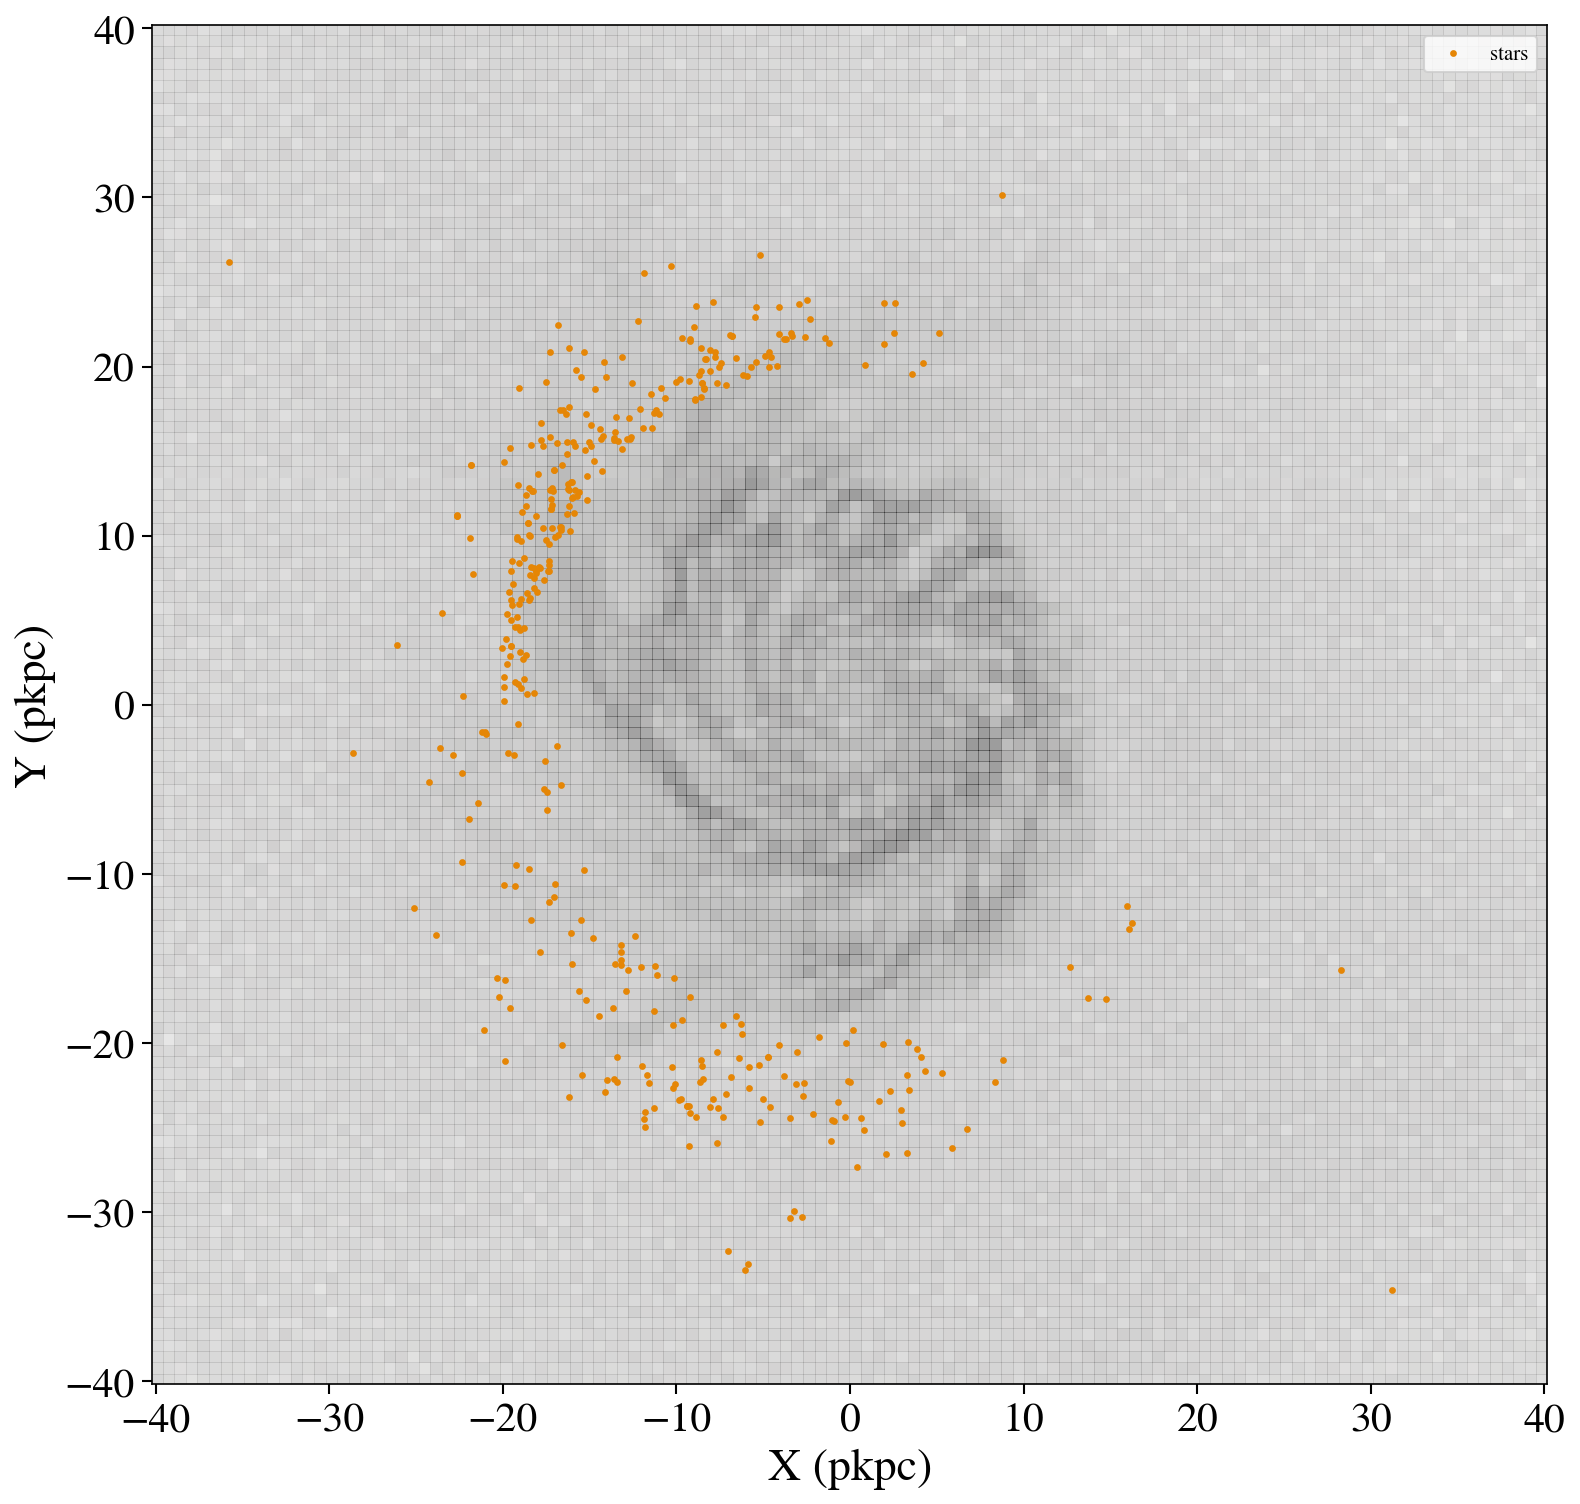

In [74]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

ax.hist2d(
    df_not_counted['Rx'],
    df_not_counted['Ry'],
    bins = 256,
    range = 0.3 * g_data.r_vir * np.array( [ [ -1., 1. ], [ -1., 1. ], ] ),
    cmap = palettable.cmocean.sequential.Gray_20_r.mpl_colormap,
    norm = plt_colors.LogNorm(),
    alpha = 0.4,
)

ax.scatter(
    df_not_counted_star['Rx'],
    df_not_counted_star['Ry'],
    color = palettable.cartocolors.qualitative.Vivid_2.mpl_colors[0],
    s = 5,
    label = 'stars',
)


ax.set_xlabel( 'X (pkpc)', fontsize=22, )
ax.set_ylabel( 'Y (pkpc)', fontsize=22, )

ax.set_xlim( -2. * r_gal, 2. * r_gal )
ax.set_ylim( -2. * r_gal, 2. * r_gal )

ax.legend()

fig

# Compare Accreted Gas to All Gas

## Get Profiles

In [75]:
def bin_in_r( r, quantity, bins=None ):
    
    if bins is None:
        bins = np.linspace( 0., g_data_prior.r_vir, 64 )
    
    stat_fns = [
        np.nanmedian,
        lambda x: np.nanpercentile( x, 16. ),
        lambda x: np.nanpercentile( x, 84. )
    ]
    result = [
        scipy.stats.binned_statistic( r, quantity, statistic=_, bins=bins )
        for _ in stat_fns
    ]
    
    return result
    

In [76]:
acc_in_rvir = df_acc_prior['R'] < g_data_prior.r_vir
R_acc_most = np.nanpercentile( df_acc_prior['R'][acc_in_rvir], 95. )
R_acc_90 = np.nanpercentile( df_acc_prior['R'][acc_in_rvir], 90. )

In [77]:
bins = np.linspace( cgm_inner, R_acc_most, 32 ).flatten()
centers = 0.5 * ( bins[1:] + bins[:-1] )

In [78]:
x_lim = [ centers[0], centers[-1] ]

In [79]:
in_rvir = np.where( g_data_prior.get_data( 'R' ) < g_data_prior.r_vir )[0]

### Radius

In [80]:
R_acc, x_edges = np.histogram(
    df_acc_prior['R'],
    bins = bins,
    weights = df_acc_prior['M'],
    density = True,
)

In [81]:
R_all, x_edges = np.histogram(
    g_data_prior.get_data( 'R' )[in_rvir],
    bins = bins,
    weights = g_data_prior.get_data( 'M' )[in_rvir],
    density = True,
)

### Temperature

In [82]:
T_acc = bin_in_r( df_acc_prior['R'], df_acc_prior['T'], bins=bins )

In [83]:
T_all = bin_in_r( g_data_prior.get_data( 'R' )[in_rvir], g_data_prior.get_data( 'T' )[in_rvir], bins=bins )

### Angular Momentum

#### Total

In [84]:
J_acc = np.array( [ df_acc_prior['L0'].values, df_acc_prior['L1'].values, df_acc_prior['L2'].values,  ]) / df_acc_prior['M'].values
Jmag_acc_raw = np.sqrt( J_acc[0]**2. + J_acc[1]**2. + J_acc[2]**2. )
Jmag_acc = bin_in_r( df_acc_prior['R'], Jmag_acc_raw, bins=bins )

In [85]:
Jmag_all_raw = g_data_prior.get_data( 'Lmag' )[in_rvir] / g_data_prior.get_data( 'M' )[in_rvir]
Jmag_all = bin_in_r( g_data_prior.get_data( 'R' )[in_rvir], Jmag_all_raw, bins=bins )

#### Aligned

In [86]:
z_hat = s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum )

In [87]:
Jz_acc_raw = np.dot( J_acc.transpose(), z_hat )
Jz_acc = bin_in_r( df_acc_prior['R'], Jz_acc_raw, bins=bins )

In [88]:
J_all = g_data_prior.get_data( 'L' ) / g_data_prior.get_data( 'M' )
Jz_all_raw = np.dot( J_all.transpose(), z_hat )[in_rvir]
Jz_all = bin_in_r( g_data_prior.get_data( 'R' )[in_rvir], Jz_all_raw, bins=bins )

#### Ratio

In [89]:
circ_acc = bin_in_r( df_acc_prior['R'], Jz_acc_raw / Jmag_acc_raw, bins=bins )

In [90]:
circ_all = bin_in_r( g_data_prior.get_data( 'R' )[in_rvir], Jz_all_raw / Jmag_all_raw, bins=bins )

## Plot

### Figure Setup

In [91]:
qcolors = palettable.cartocolors.qualitative.Pastel_10.mpl_colors

In [92]:
alpha = 0.2
alpha_fill = 0.6
alphas = R_acc / R_acc.max()

In [93]:
fig = plt.figure( figsize=( 7., 11.5 ))
# ax = plt.gca()

mosaic = '''
    R
    L
    L
    C
    C
    T
    T
    '''
ax_dict = fig.subplot_mosaic(
    mosaic,
    gridspec_kw  = { 'hspace': 0.1 },
)

### Radius

In [94]:
ax = ax_dict['R']

ax.fill_between(
    centers,
    R_all,
    color = qcolors[2],
    alpha = alpha_fill,
    label = r'within CGM at 1 Gyr prior to $z=0$',
)

ax.fill_between(
    centers,
    R_acc,
    color = qcolors[0],
    alpha = alpha_fill,
    label = 'subset in galaxy at $z=0$',
)

ax.axvline(
    R_acc_90,
    color = pm['background_linecolor'],
    linewidth = 1,
)

ax.tick_params( which='both', direction='in', labelbottom=False )
ax.tick_params( which='major', length=10, width=2 )
ax.tick_params( which='minor', length=7, width=1 )

ax.set_xlim( x_lim )
ax.set_ylim( 0, 1.3 * R_acc[0] )

ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
ax.get_yticklabels()[-2].set_verticalalignment( 'top' )

ax.legend(
    prop = { 'size': 16, },
    framealpha = 1.,
)

ax.set_ylabel( r'PDF( R )', fontsize=22 )

Text(53.083333333333336, 0.5, 'PDF( R )')

### Temperature

In [95]:
ax = ax_dict['T']

# T_bins = np.logspace( 2., 7., 64 )
# hist, x_edges, y_edges, img = ax.hist2d(
#     df_acc_prior['R'],
#     df_acc_prior['T'],
#     bins = [ bins, T_bins ],
#     density = True,
#     norm = matplotlib.colors.LogNorm(),
# )

ax.plot(
    centers,
    T_all[0].statistic,
    color = qcolors[2],
)
ax.fill_between(
    centers,
    T_all[1].statistic,
    T_all[2].statistic,
    color = qcolors[2],
    alpha = alpha,
)

for i, alpha_i in enumerate( alphas[:-1] ):
    
    def get_segment( a, offset=0. ):
        return a[i], a[i+1] - offset

    ax.plot(
        get_segment( centers, 0.4 ),
        get_segment( T_acc[0].statistic ),
        color = qcolors[0],
        alpha = alpha_i,
    )
    ax.fill_between(
        get_segment( centers, ),
        get_segment( T_acc[1].statistic ),
        get_segment( T_acc[2].statistic ),
        color = qcolors[0],
        alpha = alpha_fill * alpha_i,
        linewidth = 0,
    )

ax.axvline(
    R_acc_90,
    color = pm['background_linecolor'],
    linewidth = 1,
)

ax.tick_params( which='both', direction='in', )
ax.tick_params( which='major', length=10, width=2 )
ax.tick_params( which='minor', length=7, width=1 )

ax.get_yticklabels()[1].set_verticalalignment( 'bottom' )
ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

ax.set_yscale( 'log' )
ax.set_xlim( x_lim )
ax.set_ylim( 1e4, 1.5e6 )

ax.set_ylabel( r'$T$ [K]', fontsize=22 )

Text(32.208333333333336, 0.5, '$T$ [K]')

### Angular Momentum

In [96]:
ax = ax_dict['L']

#### Total

In [97]:
ax.plot(
    centers,
    Jmag_all[0].statistic,
    color = qcolors[2],
    label = r'$\vert \vec j \vert$',
)
ax.fill_between(
    centers,
    Jmag_all[1].statistic,
    Jmag_all[2].statistic,
    color = qcolors[2],
    alpha = alpha,
)

for i, alpha_i in enumerate( alphas[:-1] ):
    
    def get_segment( a, offset=0. ):
        return a[i], a[i+1] - offset

    ax.plot(
        get_segment( centers, 0.4 ),
        get_segment( Jmag_acc[0].statistic, ),
        color = qcolors[0],
        alpha = alpha_i,
    )
    ax.fill_between(
        get_segment( centers, ),
        get_segment( Jmag_acc[1].statistic, ),
        get_segment( Jmag_acc[2].statistic, ),
        color = qcolors[0],
        alpha = alpha_fill * alpha_i,
        linewidth = 0,
    )

#### Aligned

In [98]:
ax.plot(
    centers,
    Jz_all[0].statistic,
    color = qcolors[2],
    linestyle = '--',
    label = r'$j_z$',
)
# ax.fill_between(
#     centers,
#     Jz_all[1].statistic,
#     Jz_all[2].statistic,
#     color = qcolors[2],
#     alpha = alpha,
# )

for i, alpha_i in enumerate( alphas[:-1] ):
    
    def get_segment( a, offset=0. ):
        return a[i], a[i+1] - offset

    ax.plot(
        get_segment( centers, 0.4 ),
        get_segment( Jz_acc[0].statistic, ),
        color = qcolors[0],
        linestyle = '--',
        alpha = alpha_i,
    )
    # ax.fill_between(
    #     centers,
    #     Jz_acc[1].statistic,
    #     Jz_acc[2].statistic,
    #     color = qcolors[0],
    #     alpha = alpha,
    # )

In [99]:
ax.axvline(
    R_acc_90,
    color = pm['background_linecolor'],
    linewidth = 1,
)
text = ax.annotate(
    text = r'contains 90$\%$' + '\nof accretion',
    xy = ( R_acc_90, 0.1 ),
    xycoords = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
    xytext = ( -5, 0 ),
    textcoords = 'offset points',
    fontsize = 14,
    ha = 'right',
    va = 'bottom',
    color = pm['background_linecolor']
)
text.set_path_effects([ path_effects.Stroke(linewidth=4, foreground='white'), path_effects.Normal() ])


ax.tick_params( which='both', direction='in', labelbottom=False )
ax.tick_params( which='major', length=10, width=2 )
ax.tick_params( which='minor', length=7, width=1 )

ax.set_yscale( 'log' )
ax.set_xlim( x_lim )
# ax.set_ylim( 0, Jmag_all[2].statistic.max() )

ax.get_yticklabels()[1].set_verticalalignment( 'bottom' )
ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

l = ax.legend(
    loc = 'lower left',
    prop = { 'size': 14, },
    framealpha = 1.,
)

ax.set_ylabel( 'specific angular\nmomentum [km/s]', fontsize=22 )

Text(0.8333333333333375, 0.5, 'specific angular\nmomentum [km/s]')

### Circularity

In [100]:
ax = ax_dict['C']

ax.plot(
    centers,
    circ_all[0].statistic,
    color = qcolors[2],
)
ax.fill_between(
    centers,
    circ_all[1].statistic,
    circ_all[2].statistic,
    color = qcolors[2],
    alpha = alpha,
)

for i, alpha_i in enumerate( alphas[:-1] ):
    
    def get_segment( a, offset=0. ):
        return a[i], a[i+1] - offset

    ax.plot(
        get_segment( centers, 0.4, ),
        get_segment( circ_acc[0].statistic, ),
        color = qcolors[0],
        alpha = alpha_i,
    )
    ax.fill_between(
        get_segment( centers, ),
        get_segment( circ_acc[1].statistic, ),
        get_segment( circ_acc[2].statistic, ),
        color = qcolors[0],
        alpha = alpha_fill * alpha_i,
        linewidth = 0,
    )

ax.axvline(
    R_acc_90,
    color = pm['background_linecolor'],
    linewidth = 1,
)

ax.axhline(
    0,
    color = pm['background_linecolor'],
    linewidth = 1,
)

# ax.set_yscale( 'log' )
ax.set_ylim( -1, 1 )
ax.set_xlim( x_lim )

ax.tick_params( which='both', direction='in', labelbottom=False )
ax.tick_params( which='major', length=10, width=2 )
ax.tick_params( which='minor', length=7, width=1 )

ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

ax.set_ylabel( r'$j_z$ / $\vert \vec j \vert$', fontsize=22 )

Text(32.208333333333336, 0.5, '$j_z$ / $\\vert \\vec j \\vert$')

In [101]:
ax_dict['T'].set_xlabel( r'R [kpc]', fontsize=22 )

Text(0.5, 162.6093749999998, 'R [kpc]')

### Display and Save

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/selected_to_all_comparison/selected_to_all_comparison_m12b_md.pdf


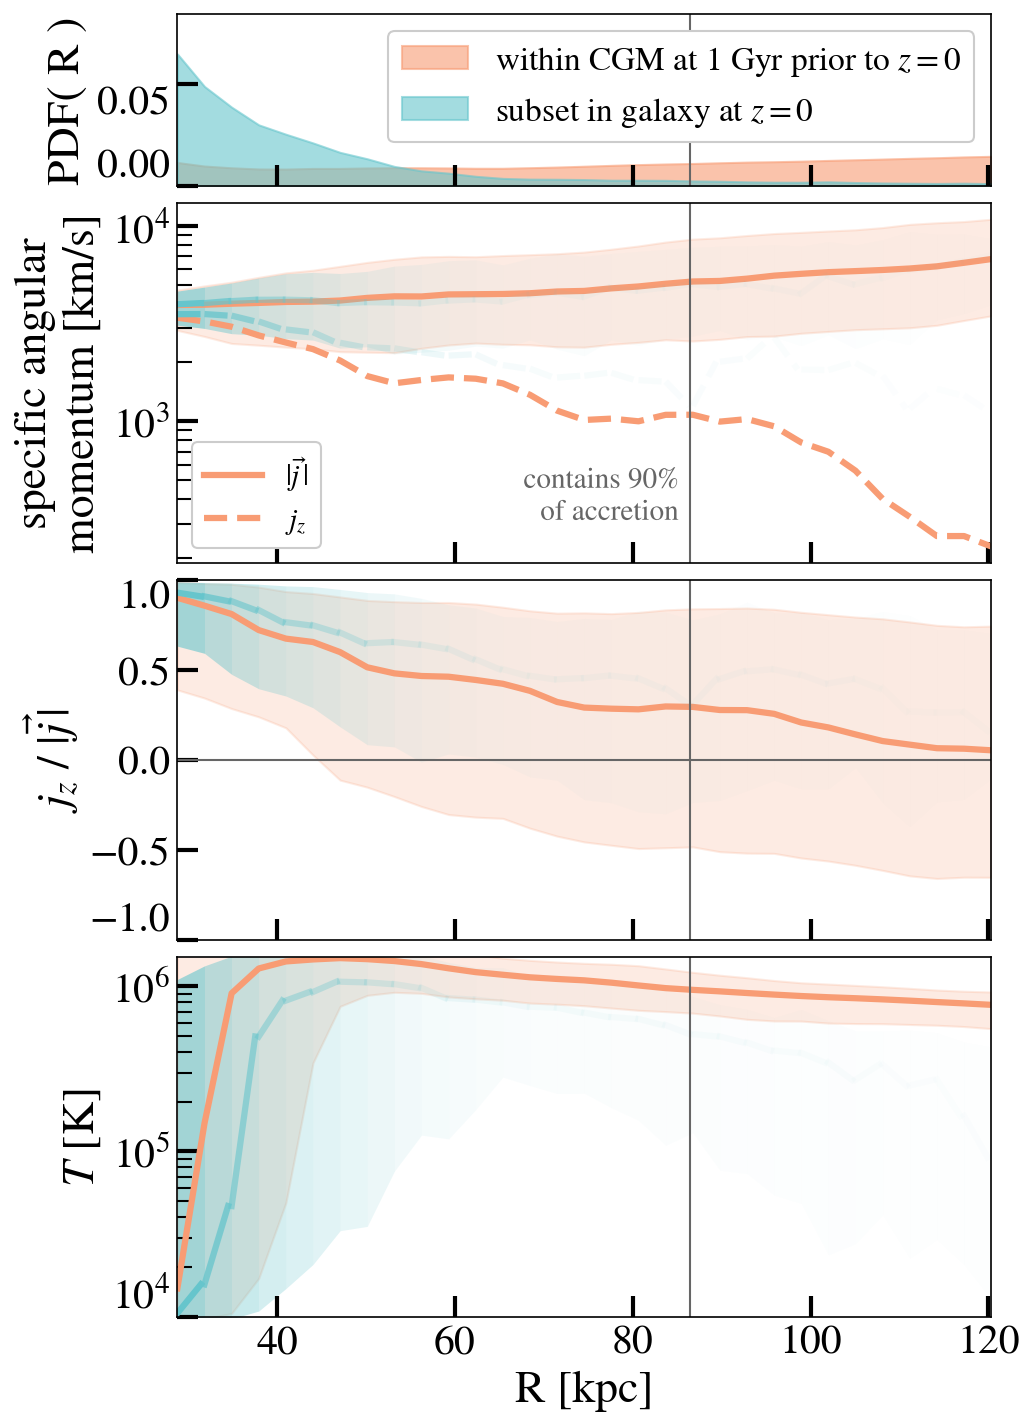

In [102]:
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'selected_to_all_comparison' ),
    save_file = 'selected_to_all_comparison_{}.pdf'.format( pm['variation'] ),

    fig = fig,
)
fig

# Pressure Profiles

In [103]:
pressure_fp = os.path.join( pm['processed_data_dir'], 'pressure_profiles.hdf5' )
pressures = verdict.Dict.from_hdf5( pressure_fp, create_nonexistent=True )

/home1/03057/zhafen/repos/verdict/verdict.py:1407: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [104]:
# Retrieve data
r = g_data_prior.get_data( 'R' )[in_rvir]
den = g_data_prior.get_data( 'NumDen' )[in_rvir]
T = g_data_prior.get_data( 'T' )[in_rvir]
nT = T * den
m = g_data_prior.get_data( 'M' )[in_rvir]
volume = m / den

In [105]:
r_bins = np.logspace( -1, np.log10( r.max() ), 128 )
nT_bins = np.logspace( np.log10( nT.min() ), np.log10( nT.max() ), 128 )

In [106]:
r_centers = 0.5 * ( r_bins[:-1] + r_bins[1:] )
nT_centers = 0.5 * ( nT_bins[:-1] + nT_bins[1:] )

In [107]:
weights = {
    'volume': volume,
    'mass': m,
}
T_cuts = {
    'none': np.arange(r.size),
    'cool': T < 10**4.8,
    'warm': ( T > 10**4.8 ) & ( T < 10**6.3 ),
    'hot': T > 10**6.3,
}

In [108]:
%matplotlib inline

<ipython-input-109-49a0387c60bd>:23: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[:,-1][:,np.newaxis]
<ipython-input-109-49a0387c60bd>:33: RuntimeWarning: invalid value encountered in true_divide
  mean = ( nT_centers * hist2d ).sum( axis=1 ) / hist2d.sum( axis=1 )
<ipython-input-109-49a0387c60bd>:23: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[:,-1][:,np.newaxis]
<ipython-input-109-49a0387c60bd>:33: RuntimeWarning: invalid value encountered in true_divide
  mean = ( nT_centers * hist2d ).sum( axis=1 ) / hist2d.sum( axis=1 )
<ipython-input-109-49a0387c60bd>:23: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[:,-1][:,np.newaxis]
<ipython-input-109-49a0387c60bd>:33: RuntimeWarning: invalid value encountered in true_divide
  mean = ( nT_centers * hist2d ).sum( axis=1 ) / hist2d.sum( axis=1 )
<ipython-input-109-49a0387c60bd>:23: RuntimeWarning: invalid value encountered in true_divide
  cdf /= cdf[:,-1][:,np.newaxis]


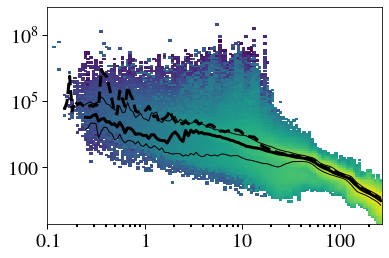

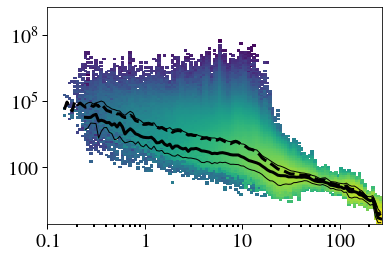

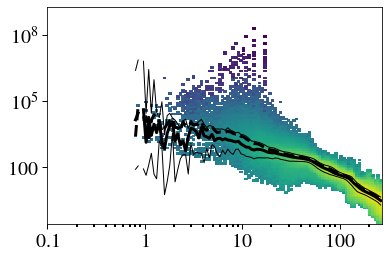

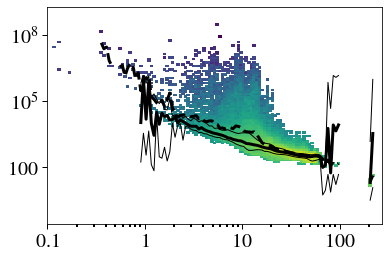

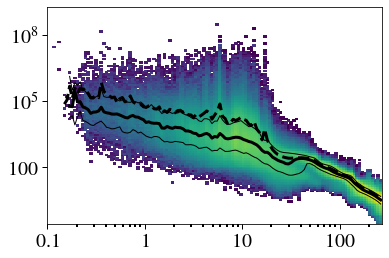

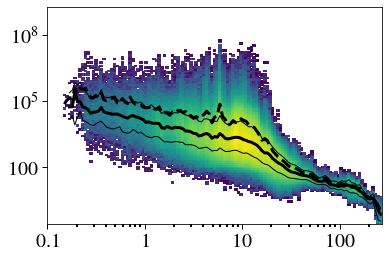

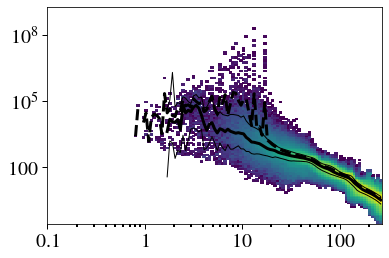

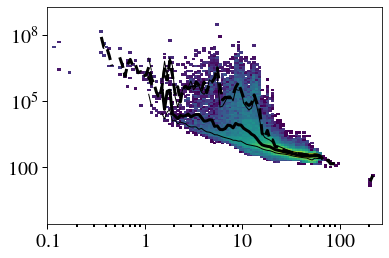

In [109]:
for wkey, weight in weights.items():
    for Tcutkey, Tcut_mask in T_cuts.items():
        fig = plt.figure()
        ax = plt.gca()
        
        hist2d, _, _, img = ax.hist2d(
            r[Tcut_mask],
            nT[Tcut_mask],
            bins = [ r_bins, nT_bins ],
            norm = matplotlib.colors.LogNorm(),
            weights = weight[Tcut_mask],
        )

        ax.set_xscale( 'log' )
        ax.set_yscale( 'log' )
        
        # Threshold for plotting the median
        hist2d_sum = hist2d.sum( axis=1 )
        below_threshold = hist2d_sum < np.percentile( weight, 16 ) * 10
        
        # Calculate weighted percentiles
        cdf = np.cumsum( hist2d, axis=1 )
        cdf /= cdf[:,-1][:,np.newaxis]
        def weighted_percentile( q ):
            result = np.array([ scipy.interpolate.interp1d( _, np.log10( nT_centers ) )( q / 100. ) for _ in cdf ])
            result[below_threshold] = np.nan
            return 10.**result
                
        # Get metrics
        median = weighted_percentile( 50 )
        low = weighted_percentile( 16 )
        high = weighted_percentile( 84 )
        mean = ( nT_centers * hist2d ).sum( axis=1 ) / hist2d.sum( axis=1 )
        
        # Plot metrics
        ax.plot(
            r_centers,
            median,
            color = 'k',
            linewidth = 3,
        )
        ax.plot(
            r_centers,
            mean,
            color = 'k',
            linewidth = 3,
            linestyle = '--',
        )
        ax.plot(
            r_centers,
            low,
            color = 'k',
            linewidth = 1,
        )
        ax.plot(
            r_centers,
            high,
            color = 'k',
            linewidth = 1,
        )
        
        # Store metrics
        sim_name = pm['variation']
        pressures.setitem( sim_name, mean, 'nT profiles', wkey, Tcutkey, 'mean', )
        pressures.setitem( sim_name, median, 'nT profiles', wkey, Tcutkey, 'median', )
        pressures.setitem( sim_name, low, 'nT profiles', wkey, Tcutkey, '16th percentile', )
        pressures.setitem( sim_name, high, 'nT profiles', wkey, Tcutkey, '84th percentile', )
        pressures.setitem( sim_name, r_bins, 'bins', 'radius' )
        pressures.setitem( sim_name, r_centers, 'centers', 'radius' )
        pressures.setitem( sim_name, nT_bins, 'bins', 'nT' )
        pressures.setitem( sim_name, nT_centers, 'centers', 'nT' )
        

In [110]:
r_centers_ckpc = r_centers * ( h_param * ( 1. + s_data.redshift ) )
vcirc = g_data_prior.halo_data.get_profile_data(
    'vcirc',
    snum,
    r_centers_ckpc,
)
M_in_r = g_data_prior.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_centers_ckpc,
) / h_param

In [111]:
pressures.setitem(
    sim_name,
    r_centers,
    'potential profiles',
    'radius',
)
pressures.setitem(
    sim_name,
    vcirc,
    'potential profiles',
    'vcirc',
)
pressures.setitem(
    sim_name,
    M_in_r,
    'potential profiles',
    'M_in_r',
)

In [112]:
pressures.to_hdf5( pressure_fp )
print( 'Saved at {}'.format( pressure_fp ) )

100%|██████████| 18/18 [00:00<00:00, 57.80it/s]

Saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/data/pressure_profiles.hdf5


# Save Data

## ID Data

In [113]:
child_ids_str = {
    True: '_split',
    False: '',
}[store_child_ids]

In [114]:
file_name = 'ids_full_hothaloacc{}.hdf5'.format( child_ids_str )
file_path = os.path.join( pm['data_dir'], file_name )
g = h5py.File( file_path, 'w' )

In [115]:
ids_to_store = {
    'out_then_in': ids_accreted,
    'all_recent_stars': ids_recent,
    'all_thin_disk_stars': ids_thin_disk,
}[pm['identification_method']]

In [116]:
g.create_dataset( 'target_ids', data=ids_to_store )

<HDF5 dataset "target_ids": shape (80903,), type "<i8">

In [117]:
if store_child_ids:
    assert pm['identification_method'] == 'out_then_in'
    g.create_dataset( 'target_child_ids', data=child_ids_accreted )

In [118]:
g.close()

In [119]:
print( 'Saved at {}'.format( file_path ) )

Saved at /scratch/03057/zhafen/hot_accretion_data/m12b_md/ids_full_hothaloacc.hdf5


## Summary Statistics Data

### Momentum

In [120]:
tot_momentum_fp = os.path.join( pm['processed_data_dir'], 'tot_momentums.hdf5' )

In [121]:
try:
    tot_momentums = verdict.Dict.from_hdf5( tot_momentum_fp )
except IOError:
    tot_momentums = verdict.Dict( {} )

/home1/03057/zhafen/repos/verdict/verdict.py:1407: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [122]:
sim_str = pm['variation']
if sim_str not in tot_momentums:
    tot_momentums[pm['variation']] = {}

In [123]:
tot_momentums[sim_str]['snum{:03d}'.format( snum )] = s_data.total_ang_momentum

In [124]:
tot_momentums[sim_str]['snum{:03d}'.format( snum_prior )] = g_data_prior.total_ang_momentum

The angles are consistent both across time and stars/gas:

In [125]:
print(
        'Change between gas angular momentum now and 1 Gyr ago: {:.2g} degrees'.format(
        np.arccos(
            np.dot(
                g_data.total_ang_momentum / np.linalg.norm( g_data.total_ang_momentum ),
                g_data_prior.total_ang_momentum / np.linalg.norm( g_data_prior.total_ang_momentum ),
            )
        ) / np.pi * 180.
    )
)

Change between gas angular momentum now and 1 Gyr ago: 2.3 degrees


In [126]:
print(
        'Change between gas angular momentum now and stellar angular momentum now: {:.2g} degrees'.format(
        np.arccos(
            np.dot(
                g_data.total_ang_momentum / np.linalg.norm( g_data.total_ang_momentum ),
                s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum ),
            )
        ) / np.pi * 180.
    )
)

Change between gas angular momentum now and stellar angular momentum now: 0.9 degrees


#### Various Total Angular Momentums

In [127]:
Js = {
    'Jstar': {
        'data': s_data,
        'mask': is_in_gal_star,
    },
    'Jthindisk': {
        'data': s_data,
        'mask': np.arange( s_data.base_data_shape[0] )[is_in_gal_star][jz_jcirc>=0.8],
    },
    'Jgasgalaxy': {
        'data': g_data,
        'mask': is_in_gal_gas,
    },
    'Jstarhalo': {
        'data': s_data,
        'mask': s_data.get_data( 'R' ) < s_data.r_vir,
    },
    'Jgashalo': {
        'data': g_data,
        'mask': g_data.get_data( 'R' ) < s_data.r_vir,
    },
    'Jdmhalo': {
        'data': d_data,
        'mask': d_data.get_data( 'R' ) < s_data.r_vir,
    },
}

In [128]:
for jkey, item in tqdm.tqdm( Js.items() ):
        
    data_source = item['data']
    mask = item['mask']
    
    # Calculate
    ang_mom = data_source.get_data( 'L' ) * 1e10 * unyt.Msun * unyt.kpc * unyt.km / unyt.s
    l = ang_mom[:,mask].to( 'Msun*kpc*km/s' )
    m = data_source.get_data( 'M' )[mask] * 1e10 * unyt.Msun
    J = l.sum( axis=1 ) / m.sum()
    Jmag = np.linalg.norm( J )
    
    # Store
    tot_momentums[sim_str]['{}_snum{:03d}'.format( jkey, snum )] = Jmag

100%|██████████| 6/6 [00:18<00:00,  3.16s/it]


In [129]:
tot_momentums.to_hdf5( tot_momentum_fp )

100%|██████████| 19/19 [00:00<00:00, 621.32it/s]


### Disk Fraction

In [130]:
bins = np.linspace( -1, 1, 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

#### Disk Fraction for All Stars

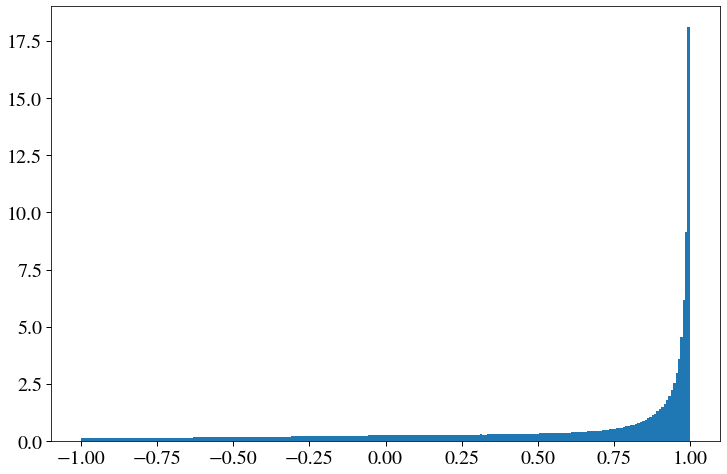

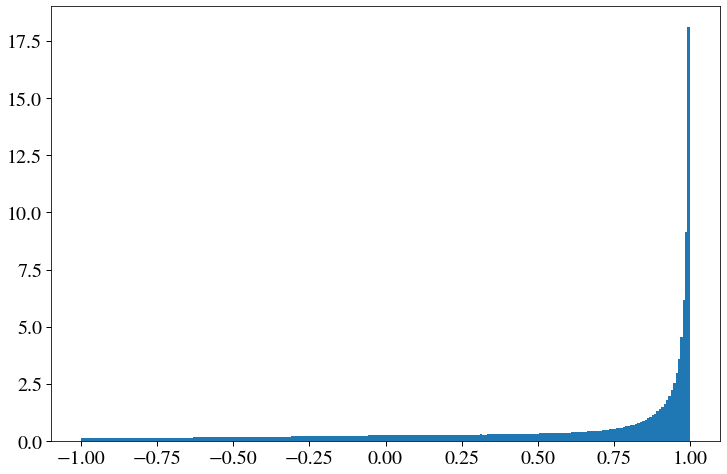

In [131]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

hist, bins, _ = ax.hist(
    jz_jmag,
    bins,
    density = True,
)
fig

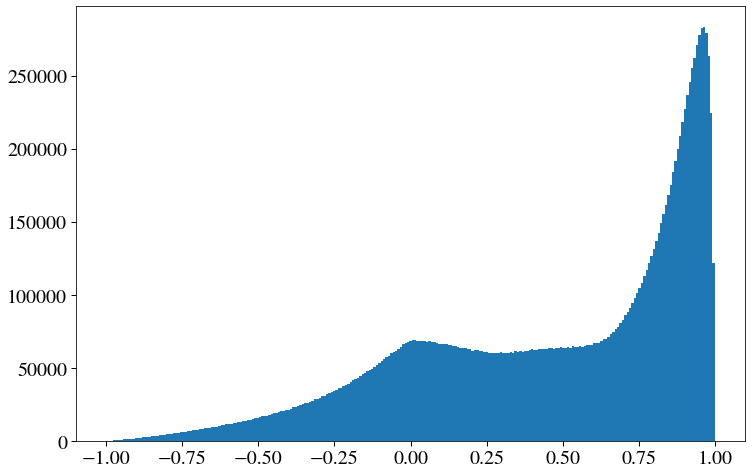

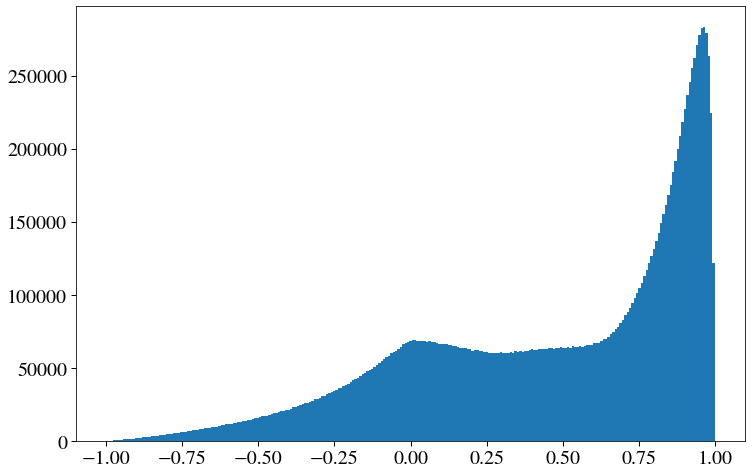

In [132]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jz_jcirc,
    bins,
)
fig

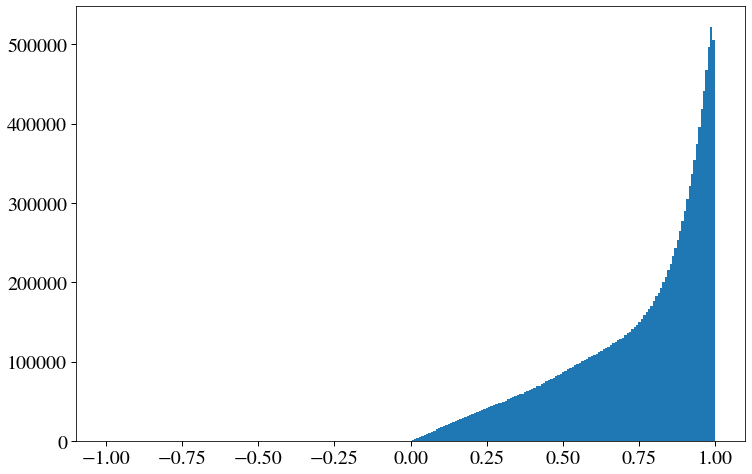

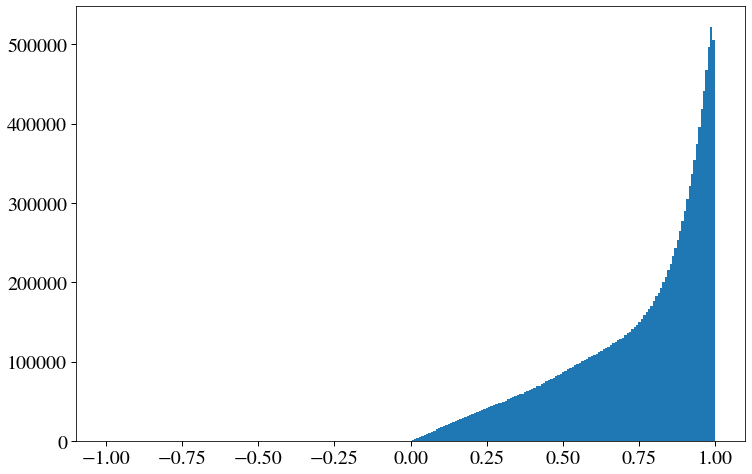

In [133]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jmag_star / j_circ,
    bins,
)
fig

In [134]:
# Calculate fractions
m_tot = m_star.sum()
is_thin_disk = jz_jcirc>=0.8
is_thick_disk = (jz_jcirc>=0.2) & (jz_jcirc<0.8)
is_disk = jz_jcirc>=0.5
thin_disk_frac = m_star[is_thin_disk].sum() / m_tot
thick_disk_frac = m_star[is_thick_disk].sum() / m_tot
disk_frac = m_star[is_disk].sum() / m_tot

In [135]:
# Open for saving
summary_fp = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
summary_data = verdict.Dict.from_hdf5( summary_fp, create_nonexistent=True )

In [136]:
# Store
if 'thin_disk_fraction' not in summary_data.keys():
    summary_data['thin_disk_fraction'] = {}
summary_data['thin_disk_fraction'][pm['variation']] = thin_disk_frac
if 'thick_disk_fraction' not in summary_data.keys():
    summary_data['thick_disk_fraction'] = {}
summary_data['thick_disk_fraction'][pm['variation']] = thick_disk_frac
summary_data.to_hdf5( summary_fp, handle_jagged_arrs='row datasets', )

100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


In [137]:
if 'jz_jmag_stars' not in summary_data.keys():
    summary_data['jz_jmag_stars'] = {
        'thin_disk': {},
        'thin_disk_recent': {},
        'thin_disk_sloanr': {},
        'centers': {},
        'bins': {},
    }
summary_data['jz_jmag_stars']['bins'][pm['variation']] = bins
summary_data['jz_jmag_stars']['centers'][pm['variation']] = centers

In [138]:
summary_data['jz_jmag_stars']['thin_disk'][pm['variation']] = hist

#### Disk Fraction for Recent Stars

In [139]:
recent_in_gal = recent[is_in_gal_star]

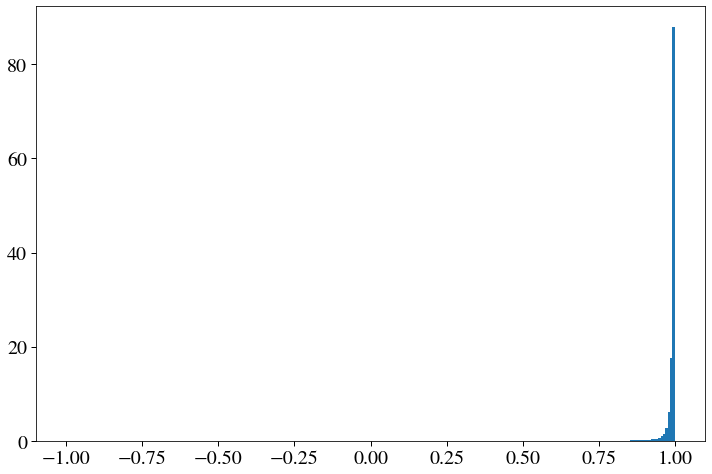

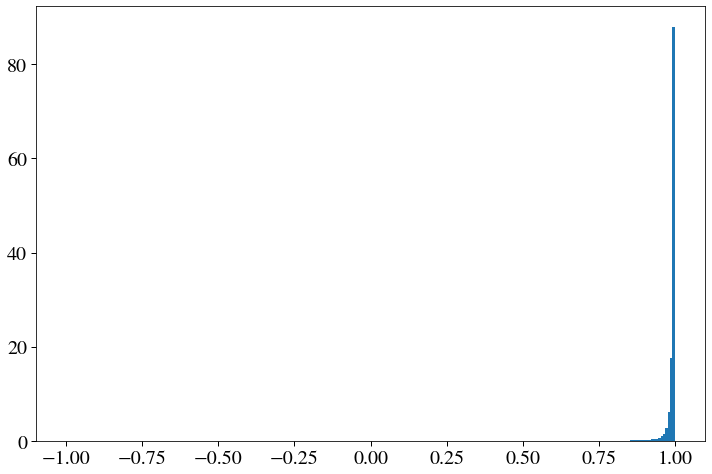

In [140]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

hist, bins, _ = ax.hist(
    jz_jmag[recent_in_gal],
    bins,
    density = True,
)
fig

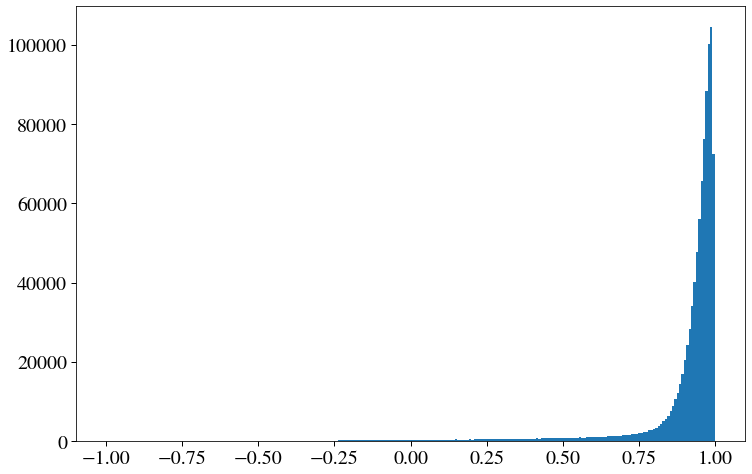

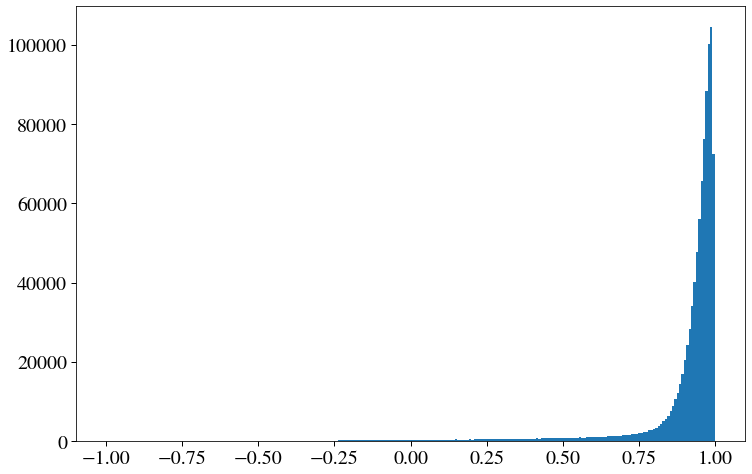

In [141]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jz_jcirc[recent_in_gal],
    bins,
)
fig

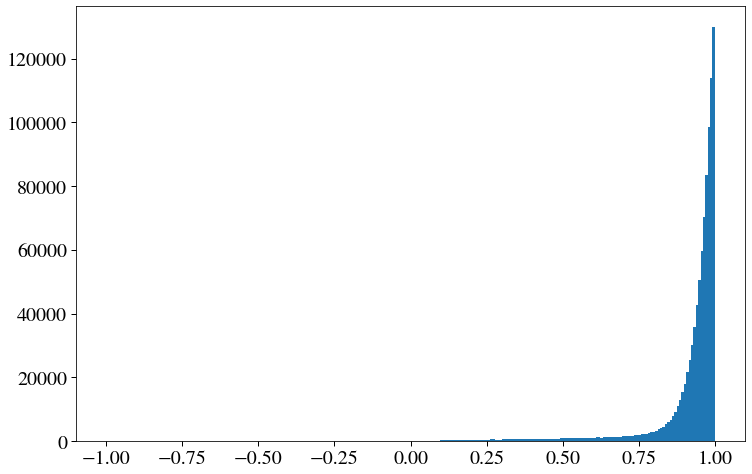

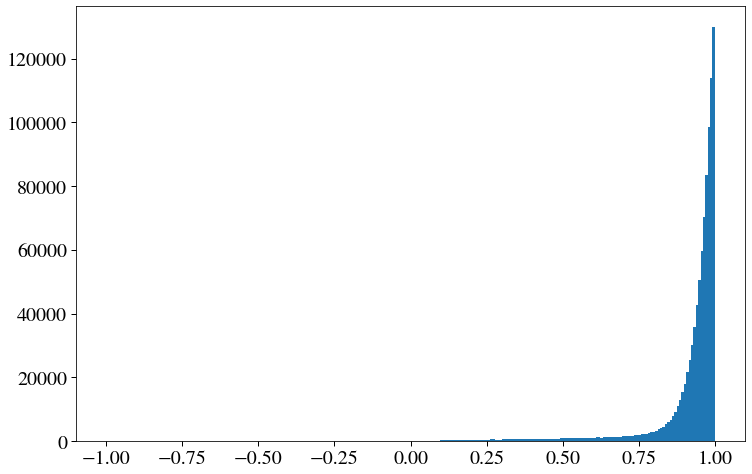

In [142]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    ( jmag_star / j_circ )[recent_in_gal],
    bins,
)
fig

In [143]:
# Calculate fractions
m_tot = m_star[recent_in_gal].sum()
thin_disk_frac = m_star[is_thin_disk & recent_in_gal].sum() / m_tot
thick_disk_frac = m_star[is_thick_disk & recent_in_gal].sum() / m_tot

In [144]:
# Store
if 'thin_disk_fraction_recent' not in summary_data.keys():
    summary_data['thin_disk_fraction_recent'] = {}
summary_data['thin_disk_fraction_recent'][pm['variation']] = thin_disk_frac
if 'thick_disk_fraction_recent' not in summary_data.keys():
    summary_data['thick_disk_fraction_recent'] = {}
summary_data['thick_disk_fraction_recent'][pm['variation']] = thick_disk_frac

In [145]:
summary_data['jz_jmag_stars']['thin_disk_recent'][pm['variation']] = hist

#### Disk Fraction for Luminous Stars

In [146]:
luminosity = luminosity_yu.get_attenuated_stellar_luminosities(
    BAND_IDS = [ 3, ],
    stellar_age = lookback_time,
    stellar_metallicity = s_data.get_data( 'Z' ),
    stellar_mass = s_data.get_data( 'M' ),
)[0]
luminosity_in_gal = luminosity[is_in_gal_star]

Calculating M/L in Sloan r (3,3)


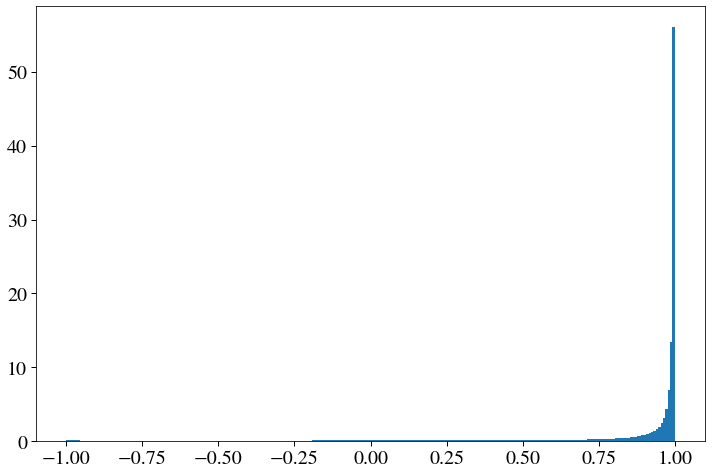

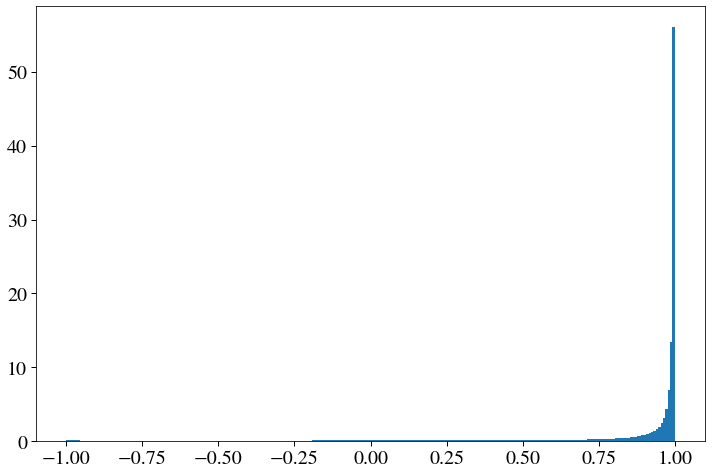

In [147]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

hist, bins, _ = ax.hist(
    jz_jmag,
    bins,
    weights = luminosity_in_gal,
    density = True,
)
fig

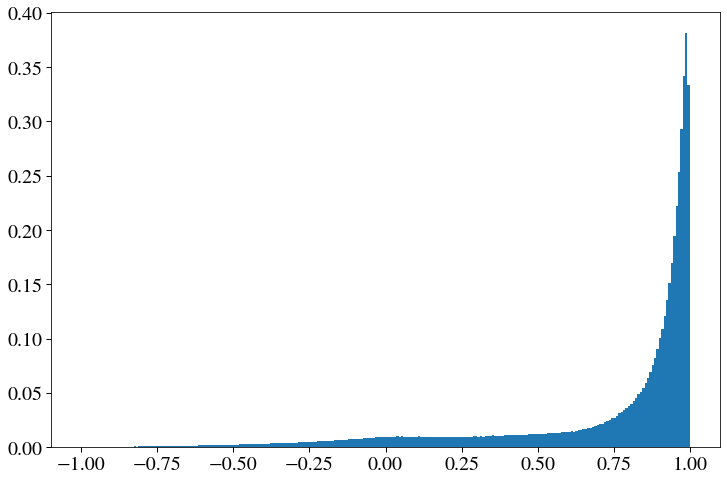

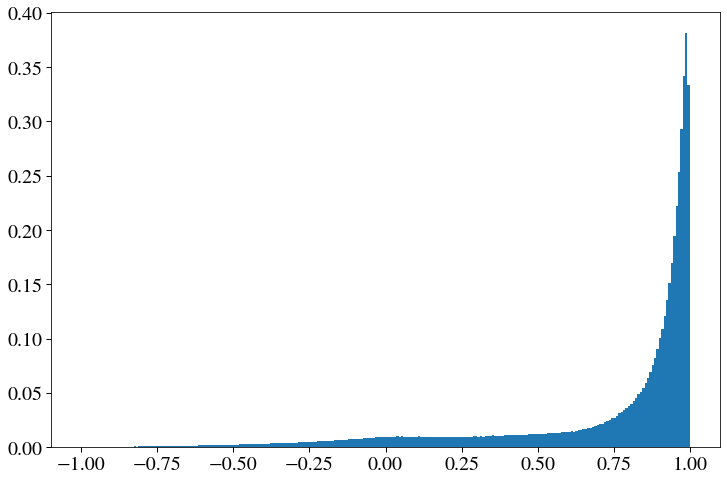

In [148]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    jz_jcirc,
    bins,
    weights = luminosity_in_gal,
)
fig

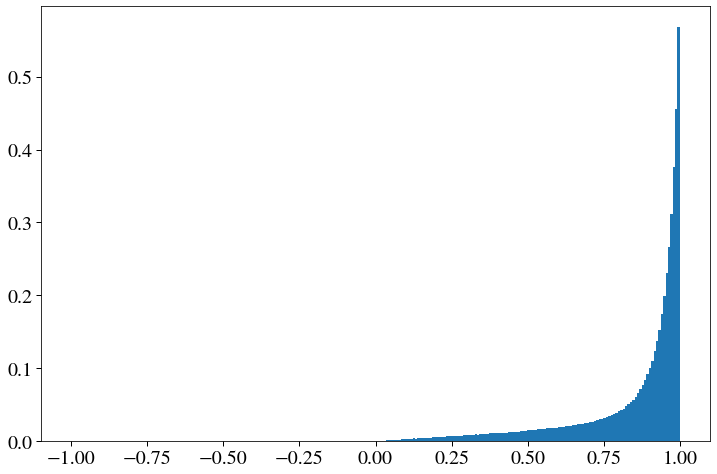

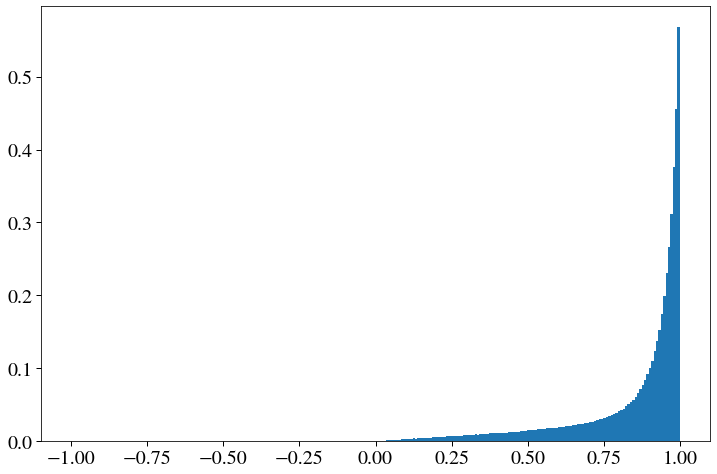

In [149]:
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

_ = ax.hist(
    ( jmag_star / j_circ ),
    bins,
    weights = luminosity_in_gal,
)
fig

In [150]:
# Calculate fractions
weights = luminosity_in_gal * m_star
m_tot_weighted = weights.sum()
thin_disk_frac = weights[is_thin_disk].sum() / m_tot_weighted
thick_disk_frac = weights[is_thick_disk].sum() / m_tot_weighted

In [151]:
# Store
if 'thin_disk_fraction_sloanr' not in summary_data.keys():
    summary_data['thin_disk_fraction_sloanr'] = {}
summary_data['thin_disk_fraction_sloanr'][pm['variation']] = thin_disk_frac
if 'thick_disk_fraction_sloanr' not in summary_data.keys():
    summary_data['thick_disk_fraction_sloanr'] = {}
summary_data['thick_disk_fraction_sloanr'][pm['variation']] = thick_disk_frac

In [152]:
summary_data['jz_jmag_stars']['thin_disk_sloanr'][pm['variation']] = hist

In [153]:
summary_data.keys()

dict_keys(['Rcools', 'Rcools_rgal', 'before_after_plot_data', 'cosphi', 'cosphi_stars', 'disk_half_height', 'disk_radius', 'f_hot', 'f_superthin', 'f_thin', 'jz_jmag_stars', 'jzjmag', 'n_accreted', 'n_hot', 'n_tracked', 'n_valid', 'sigma_r', 'tchange_offset', 'thick_disk_fraction', 'thick_disk_fraction_recent', 'thick_disk_fraction_sloanr', 'thin_disk_fraction', 'thin_disk_fraction_recent', 'thin_disk_fraction_sloanr', 'v_rot'])

In [ ]:
summary_data.to_hdf5( summary_fp, handle_jagged_arrs='row datasets', )

 12%|█▏        | 3/25 [00:01<00:09,  2.28it/s]

### z/R Distribution
For thin-disk stars.

In [ ]:
# Calculate phi
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir, )[is_in_gal_star]
costheta = z / s_data.get_data( 'R' )[is_in_gal_star]

In [ ]:
bins = np.linspace( -1, 1, 256 )
centers = bins[:-1] + 0.5 * ( bins[1] - bins[0] )

In [ ]:
# Calc hists and plot
fig = plt.figure( figsize=(12,8), facecolor='w' )
ax = plt.gca()

dist, bins, patches = ax.hist(
    costheta,
    bins,
    histtype = 'step',
    linewidth = 3,
    color = '0.3',
    density = True,
    label = 'all',
)

thin_disk_dist, bins, patches = ax.hist(
    costheta[is_thin_disk],
    bins,
    histtype = 'step',
    linewidth = 1,
    color = 'k',
    density = True,
    label = 'thin disk all',
)

dist, bins, patches = ax.hist(
    costheta[is_thick_disk],
    bins,
    histtype = 'step',
    linewidth = 1,
    color = 'k',
    density = True,
    label = 'thick disk all',
    linestyle = '--',
)

thin_disk_dist_recent, bins, patches = ax.hist(
    costheta[is_thin_disk & recent_in_gal],
    bins,
    histtype = 'step',
    linewidth = 3,
    color = 'k',
    density = True,
    label = 'thin disk',
)

dist, bins, patches = ax.hist(
    costheta[is_thick_disk & recent_in_gal],
    bins,
    histtype = 'step',
    linewidth = 3,
    color = 'k',
    density = True,
    label = 'thick disk',
    linestyle = '--',
)

disk_dist, bins, patches = ax.hist(
    costheta[is_disk],
    bins,
    histtype = 'step',
    linewidth = 1,
    color = 'k',
    density = True,
    label = 'disk all',
    linestyle = ':',
)

disk_dist_recent, bins, patches = ax.hist(
    costheta[is_disk & recent_in_gal],
    bins,
    histtype = 'step',
    linewidth = 3,
    color = 'k',
    density = True,
    label = 'disk',
    linestyle = ':',
)

ax.legend()

ax.set_xlim( -1, 1 )

fig

In [ ]:
# Store
if 'cosphi_stars' not in summary_data:
    summary_data['cosphi_stars'] = {
        'thin_disk': {},
        'thin_disk_recent': {},
        'disk': {},
        'disk_recent': {},
        'centers': centers,
        'bins': bins,
    }

In [ ]:
summary_data['cosphi_stars']['thin_disk'][pm['variation']] = thin_disk_dist
summary_data['cosphi_stars']['thin_disk_recent'][pm['variation']] = thin_disk_dist_recent

In [ ]:
summary_data['cosphi_stars']['disk'][pm['variation']] = disk_dist
summary_data['cosphi_stars']['disk_recent'][pm['variation']] = disk_dist_recent

In [ ]:
summary_data.to_hdf5( summary_fp, handle_jagged_arrs='row datasets', )

### Disk Radius and Height

In [ ]:
if 'disk_radius' not in summary_data:
    summary_data['disk_radius'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
        'recent_thin_disk_stars': {},
    }
if 'disk_half_height' not in summary_data:
    summary_data['disk_half_height'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
        'recent_thin_disk_stars': {},
    }

#### Gas

In [ ]:
is_cold_gas = g_data.get_data( 'T' ) < 1.5e4

In [ ]:
is_in_outer_boundary = g_data.get_data( 'R' ) < 0.15 * g_data.r_vir

In [ ]:
r_cold_gas_in_boundary = g_data.get_data( 'R' )[is_cold_gas & is_in_outer_boundary]

In [ ]:
r_d = np.percentile( r_cold_gas_in_boundary, 85 )

In [ ]:
z = np.dot( g_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( g_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [ ]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [ ]:
half_height = np.percentile( z_in, 85 )

In [ ]:
# Store
summary_data['disk_radius']['T<1.5e4 gas'][pm['variation']] = r_d
summary_data['disk_half_height']['T<1.5e4 gas'][pm['variation']] = half_height

In [ ]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

#### Stars

In [ ]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.15 * s_data.r_vir

In [ ]:
r_in_boundary = s_data.get_data( 'R' )[is_in_outer_boundary]

In [ ]:
r_d = np.percentile( r_in_boundary, 85 )

In [ ]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [ ]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [ ]:
half_height = np.percentile( z_in, 85 )

In [ ]:
# Store
summary_data['disk_radius']['stars'][pm['variation']] = r_d
summary_data['disk_half_height']['stars'][pm['variation']] = half_height

In [ ]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

#### Young Stars

In [ ]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.15 * s_data.r_vir

In [ ]:
r_in_boundary = s_data.get_data( 'R' )[is_in_outer_boundary & recent]

In [ ]:
r_d = np.percentile( r_in_boundary, 85 )

In [ ]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [ ]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [ ]:
half_height = np.percentile( z_in, 85 )

In [ ]:
# Store
summary_data['disk_radius']['recent_stars'][pm['variation']] = r_d
summary_data['disk_half_height']['recent_stars'][pm['variation']] = half_height

In [ ]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

#### Young Thin-Disk Stars

In [ ]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.15 * s_data.r_vir

In [ ]:
# Star masses enclosed
r_star = s_data.get_data( 'R' )[is_in_outer_boundary & recent]
r_star[r_star > s_data.r_vir] = np.nan
r_star_ckpc = r_star / ( h_param * ( 1. + s_data.redshift ) )
M_enc_star = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_star_ckpc
) / h_param

In [ ]:
# Get grid masses enclose
r_grid = np.linspace( 0.00001, s_data.r_vir, 1024 )
r_grid_ckpc = r_grid / ( h_param * ( 1. + s_data.redshift ) )
M_enc_grid = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_grid_ckpc
) / h_param
M_enc_grid[np.isnan(M_enc_grid)] = 0.
M_enc_grid[np.arange(M_enc_grid.size)>np.argmax(M_enc_grid)] = M_enc_grid.max()

In [ ]:
# Get potential energy
pot_grid = unyt.G * scipy.integrate.cumtrapz( M_enc_grid/r_grid**2., r_grid, initial=0 ) * unyt.Msun / unyt.kpc
pot_grid -= pot_grid[-1]
pot_grid -= unyt.G * g_data.m_vir * unyt.Msun / ( g_data.r_vir * unyt.kpc )
pot_grid = pot_grid.to( 'm**2/s**2' )
pot_fn = lambda x : scipy.interpolate.interp1d( r_grid, pot_grid )( x ) * unyt.m**2. / unyt.s**2.

In [ ]:
# Get energy for a grid, using virial theorem
spec_e_grid = pot_grid + 0.5 * unyt.G * M_enc_grid * unyt.Msun / ( r_grid * unyt.kpc )

In [ ]:
# Star potential energy, specific energy
pot_star = pot_fn( r_star )
v_star = s_data.get_data( 'Vmag' )[is_in_outer_boundary & recent] * unyt.km / unyt.s
spec_e_star =  pot_star +  0.5 * v_star**2.

In [ ]:
# What radii particles would be at if they were circular with the same energy
spec_e_star[spec_e_star>spec_e_grid.max()] = np.nan
r_circ = scipy.interpolate.interp1d( spec_e_grid, r_grid )( spec_e_star )

In [ ]:
# Circular momentum
r_circ_ckpc = r_circ / ( h_param * ( 1. + s_data.redshift ) )
M_enc_circ = s_data.halo_data.get_profile_data(
    'M_in_r',
    snum,
    r_circ_ckpc
) / h_param
j_circ = np.sqrt( unyt.G * M_enc_circ * unyt.Msun * r_circ * unyt.kpc)

In [ ]:
# Angular momentum
ang_mom_dir = s_data.total_ang_momentum / np.linalg.norm( s_data.total_ang_momentum )
l_units = unyt.Msun * unyt.kpc * unyt.km / unyt.s
lz_star = np.dot( s_data.get_data( 'L', ).transpose(), ang_mom_dir )[is_in_outer_boundary & recent] * l_units
lmag_star = s_data.get_data( 'Lmag' )[is_in_outer_boundary & recent] * l_units
m_star = s_data.get_data( 'M' )[is_in_outer_boundary & recent] * unyt.Msun
jz_star = lz_star / m_star
jmag_star = lmag_star / m_star

In [ ]:
# Ratios
jz_jcirc_recent = jz_star / j_circ
jz_jmag_recent = jz_star / jmag_star
is_thin_disk = jz_jcirc_recent >= 0.8

In [ ]:
r_in_boundary = s_data.get_data( 'R' )[is_in_outer_boundary & recent][is_thin_disk]

In [ ]:
r_d = np.percentile( r_in_boundary, 85 )

In [ ]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = np.linalg.norm( s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis], axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < r_d
is_in_perpendicularly = r_perp < r_d

In [ ]:
z_in = np.abs( z[is_in_vertically & is_in_perpendicularly] )

In [ ]:
half_height = np.percentile( z_in, 85 )

In [ ]:
# Store
if 'recent_thin_disk_stars' not in summary_data['disk_radius']:
    summary_data['disk_radius']['recent_thin_disk_stars'] = {}
if 'recent_thin_disk_stars' not in summary_data['disk_half_height']:
    summary_data['disk_half_height']['recent_thin_disk_stars'] = {}
summary_data['disk_radius']['recent_thin_disk_stars'][pm['variation']] = r_d
summary_data['disk_half_height']['recent_thin_disk_stars'][pm['variation']] = half_height

In [ ]:
print( 'Rd = {:.3g}, hd = {:.3g}, Rd/hd = {:.3g}'.format( r_d, half_height, r_d / half_height ) )

#### Finish Storing

In [ ]:
summary_data.to_hdf5( summary_fp, handle_jagged_arrs='row datasets', )

### Disk Rotational Velocity and Sigma

In [ ]:
if 'v_rot' not in summary_data:
    summary_data['v_rot'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
    }
if 'sigma_r' not in summary_data:
    summary_data['sigma_r'] = {
        'T<1.5e4 gas': {},
        'stars': {},
        'recent_stars': {},
    }

#### Gas

In [ ]:
is_cold_gas = g_data.get_data( 'T' ) < 1.5e4

In [ ]:
is_in_outer_boundary = g_data.get_data( 'R' ) < 0.1 * g_data.r_vir

In [ ]:
r_in_boundary = g_data.get_data( 'R' )[is_in_outer_boundary & is_cold_gas]

In [ ]:
r_e_cold_gas = np.percentile( r_in_boundary, 50 )

In [ ]:
z = np.dot( g_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = g_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis]
r_perp_mag = np.linalg.norm( r_perp, axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < 0.1
is_in_perpendicularly = r_perp_mag < 0.25 * r_e_cold_gas

In [ ]:
# Calculate vtan
vz = np.dot( g_data.get_data( 'V' ).transpose(), ang_mom_dir )
s_hat = r_perp / r_perp_mag
vs = ( g_data.get_data( 'V' ) * s_hat ).sum( axis=0 )
vtan = g_data.get_data( 'V' ) - vz * ang_mom_dir[:,np.newaxis] - vs * s_hat
vtan_mag = np.linalg.norm( vtan, axis=0 )

In [ ]:
vrot = np.mean( vtan_mag[is_in_vertically & is_in_perpendicularly & is_cold_gas] )

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.hist(
    vtan_mag[is_in_vertically & is_in_perpendicularly],
    bins = 32,
)

ax.axvline(
    vrot,
    color = 'k',
)

vmax = s_data.halo_data.get_mt_data( 'Vmax', snums=[ snum, ] )
ax.axvline(
    vmax,
    color = 'k',
    linestyle = '--',
)

fig

In [ ]:
r_hat = g_data.get_data( 'P' ) / g_data.get_data( 'R' )
vr = ( g_data.get_data( 'V' ) * r_hat ).sum( axis=0 )
masses = g_data.get_data( 'M' )

In [ ]:
r_bins = np.linspace( 0, 0.1 * g_data.r_vir, 16 )
sigma_r = []
weights = []
for i, r_start in enumerate( tqdm.tqdm( r_bins[:-1] ) ):
    in_bin = ( g_data.get_data( 'R' ) > r_start ) & ( g_data.get_data( 'R' ) < r_bins[i+1] )
    
    sigma_r_i = np.std( vr[in_bin & is_cold_gas] )
    sigma_r.append( sigma_r_i )
    weights.append( masses[in_bin & is_cold_gas].sum() )
sigma_r = np.array( sigma_r )
weights = np.array( weights )

In [ ]:
sigma_r = ( sigma_r * weights ).sum() / weights.sum()

In [ ]:
# Store
summary_data['v_rot']['T<1.5e4 gas'][pm['variation']] = vrot
summary_data['sigma_r']['T<1.5e4 gas'][pm['variation']] = sigma_r

In [ ]:
print( 'Vrot = {:.3g}, sigma = {:.3g}, Vrot/sigma = {:.3g}'.format( vrot, sigma_r, vrot / sigma_r ) )

#### Stars

In [ ]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.1 * s_data.r_vir

In [ ]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis]
r_perp_mag = np.linalg.norm( r_perp, axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < 0.1
is_in_perpendicularly = r_perp_mag < 0.25 * r_e_cold_gas

In [ ]:
# Calculate vtan
vz = np.dot( s_data.get_data( 'V' ).transpose(), ang_mom_dir )
s_hat = r_perp / r_perp_mag
vs = ( s_data.get_data( 'V' ) * s_hat ).sum( axis=0 )
vtan = s_data.get_data( 'V' ) - vz * ang_mom_dir[:,np.newaxis] - vs * s_hat
vtan_mag = np.linalg.norm( vtan, axis=0 )

In [ ]:
vrot = np.mean( vtan_mag[is_in_vertically & is_in_perpendicularly] )

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.hist(
    vtan_mag[is_in_vertically & is_in_perpendicularly],
    bins = 32,
)

ax.axvline(
    vrot,
    color = 'k',
)

vmax = s_data.halo_data.get_mt_data( 'Vmax', snums=[ snum, ] )
ax.axvline(
    vmax,
    color = 'k',
    linestyle = '--',
)

fig

In [ ]:
r_hat = s_data.get_data( 'P' ) / s_data.get_data( 'R' )
vr = ( s_data.get_data( 'V' ) * r_hat ).sum( axis=0 )
masses = s_data.get_data( 'M' )

In [ ]:
r_bins = np.linspace( 0, 0.1 * s_data.r_vir, 16 )
sigma_r = []
weights = []
for i, r_start in enumerate( tqdm.tqdm( r_bins[:-1] ) ):
    in_bin = ( s_data.get_data( 'R' ) > r_start ) & ( s_data.get_data( 'R' ) < r_bins[i+1] )
    
    sigma_r_i = np.std( vr[in_bin] )
    sigma_r.append( sigma_r_i )
    weights.append( masses[in_bin].sum() )
sigma_r = np.array( sigma_r )
weights = np.array( weights )

In [ ]:
sigma_r = ( sigma_r * weights ).sum() / weights.sum()

In [ ]:
# Store
summary_data['v_rot']['stars'][pm['variation']] = vrot
summary_data['sigma_r']['stars'][pm['variation']] = sigma_r

In [ ]:
print( 'Vrot = {:.3g}, sigma = {:.3g}, Vrot/sigma = {:.3g}'.format( vrot, sigma_r, vrot / sigma_r ) )

#### Young Stars

In [ ]:
is_in_outer_boundary = s_data.get_data( 'R' ) < 0.1 * s_data.r_vir

In [ ]:
z = np.dot( s_data.get_data( 'P' ).transpose(), ang_mom_dir )
r_perp = s_data.get_data( 'P' ) - z * ang_mom_dir[:,np.newaxis]
r_perp_mag = np.linalg.norm( r_perp, axis=0 )

In [ ]:
is_in_vertically = np.abs( z ) < 0.1
is_in_perpendicularly = r_perp_mag < 0.25 * r_e_cold_gas

In [ ]:
# Calculate vtan
vz = np.dot( s_data.get_data( 'V' ).transpose(), ang_mom_dir )
s_hat = r_perp / r_perp_mag
vs = ( s_data.get_data( 'V' ) * s_hat ).sum( axis=0 )
vtan = s_data.get_data( 'V' ) - vz * ang_mom_dir[:,np.newaxis] - vs * s_hat
vtan_mag = np.linalg.norm( vtan, axis=0 )

In [ ]:
vrot = np.mean( vtan_mag[is_in_vertically & is_in_perpendicularly & recent] )

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.hist(
    vtan_mag[is_in_vertically & is_in_perpendicularly],
    bins = 32,
)

ax.axvline(
    vrot,
    color = 'k',
)

vmax = s_data.halo_data.get_mt_data( 'Vmax', snums=[ snum, ] )
ax.axvline(
    vmax,
    color = 'k',
    linestyle = '--',
)

fig

In [ ]:
r_hat = s_data.get_data( 'P' ) / s_data.get_data( 'R' )
vr = ( s_data.get_data( 'V' ) * r_hat ).sum( axis=0 )
masses = s_data.get_data( 'M' )

In [ ]:
r_bins = np.linspace( 0, 0.1 * s_data.r_vir, 16 )
sigma_r = []
weights = []
for i, r_start in enumerate( tqdm.tqdm( r_bins[:-1] ) ):
    in_bin = ( s_data.get_data( 'R' ) > r_start ) & ( s_data.get_data( 'R' ) < r_bins[i+1] )
    
    sigma_r_i = np.std( vr[in_bin & recent] )
    sigma_r.append( sigma_r_i )
    weights.append( masses[in_bin & recent].sum() )
sigma_r = np.array( sigma_r )
weights = np.array( weights )

In [ ]:
sigma_r = ( sigma_r * weights ).sum() / weights.sum()

In [ ]:
# Store
summary_data['v_rot']['recent_stars'][pm['variation']] = vrot
summary_data['sigma_r']['recent_stars'][pm['variation']] = sigma_r

In [ ]:
print( 'Vrot = {:.3g}, sigma = {:.3g}, Vrot/sigma = {:.3g}'.format( vrot, sigma_r, vrot / sigma_r ) )

#### Finish Storing

In [ ]:
summary_data.to_hdf5( summary_fp, handle_jagged_arrs='row datasets', )

# Firefly Visualization

## Format Data

### Raw Data

In [ ]:
coords = s_data.get_data( 'P' )[:,is_in_gal_star].transpose()

In [ ]:
velocities = s_data.get_data( 'V' )[:,is_in_gal_star].transpose()

In [ ]:
fields_dict = {
    'Age': lookback_time[is_in_gal_star],
    'Circularity': jz_jcirc.value,
    'MomentumAngle': jz_jmag.value,
}

### Sample Indices

In [ ]:
inds = np.arange( coords.shape[0] )

In [ ]:
premask = lookback_time[is_in_gal_star] < 1.
if premask is not None:
    inds = inds[premask]

In [ ]:
n_max = 1000000
if inds.size > n_max:
    inds = np.random.choice( inds, n_max, replace=False )
coords = coords[inds,:]
velocities = velocities[inds,:]

In [ ]:
fields = []
field_names = []
for key, item in fields_dict.items():
    item = item[inds]
    fields.append( item )
    field_names.append( key )

In [ ]:
fields = np.array( fields )

### Transfer to Reader

In [ ]:
import Firefly.data_reader as firefly_readers

In [ ]:
reader = firefly_readers.ArrayReader(
    coords,
    fields = fields,
    field_names = field_names,
    write_jsons_to_disk = False,
)

In [ ]:
reader.settings['sizeMult']['PGroup_0'] = 0.01

In [ ]:
# reader.settings.printKeys()

## View Data

In [ ]:
from Firefly.server import spawnFireflyServer, killAllFireflyServers

In [ ]:
if pm['inline_firefly']:
    process = spawnFireflyServer(9299)

In [ ]:
if pm['inline_firefly']:
    reader.sendDataViaFlask(9299)

In [ ]:
if pm['inline_firefly']:
    killAllFireflyServers()